**Titanic - Survival Prediction**
----------------------------------------------
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

The Challenge
----------------------------------------------
Build a predictive model that answers the question: “**what sorts of people were more likely to survive?**” using passenger data (ie name, age, gender, socio-economic class, etc).

Data Dictionary
----------------------------------------------
- Survived - Survival (0 = No, 1 = Yes)
- Pclass - Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
- Name - Name of passenger
- Sex - Male or female
- Age - Age of passenger
- SibSp - # of siblings/spouses aboard the Titanic
- Parch - # of parents/children aboard the TItanic
- Ticket - Ticket number
- Fare - Passenger Fare
- Cabin - Cabin Number
- Embarked - Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)



#Import Library & Dataset

In [10]:
# The other version of tensorflow does not work well with the codes taht I have used in this notebook, so make sure your libraries are the same as mine
!pip install keras==2.12.0

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import random

# Suppress warnings from displaying to console
import warnings
warnings.filterwarnings("ignore")

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)

# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# To build models for prediction
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, recall_score, precision_score, f1_score, accuracy_score
from sklearn import tree

# To encode categorical variables
from sklearn.preprocessing import LabelEncoder

# For tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#AUC-ROC Tuning
from sklearn.metrics import roc_curve
from matplotlib import pyplot

# To check model performance
from sklearn.metrics import make_scorer,mean_squared_error, r2_score, mean_absolute_error

#Import tensorflow for deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout,BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adamax, Adam
from tensorflow.keras import backend

Import Dataset

In [12]:
titantrain = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Titanic/titanic_train.csv')
titantest = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Titanic//titanic_test.csv')
titansubmission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Titanic//titanic_gender_submission.csv')

Create copy of each dataset

In [13]:
#This is done to protect the data, in case you accidentally deleted the data (better be safe than sorry)
titantrain_copy = titantrain.copy()
titantest_copy = titantest.copy()
titansubmission_copy = titansubmission.copy()

Seeing what each data looks like

In [14]:
#This is the data to be tested
titantest.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [15]:
#data that will be used to train the model
titantrain.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [16]:
#This is what our data to be submitted should look like
titansubmission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


#Understanding the Data

In [17]:
#This function will study the data's shape, datatype, number of null data and number of duplicate data.
def studydata(df):
    print("Shape:")
    print(df.shape)
    print("\nInfo:")
    print(df.info())
    print("\nNull:")
    print(df.isnull().sum())
    print("\nDuplicates:")
    print(df.duplicated().sum())

    # print("\nHead:")
    # print(df.head().T)
    # print("\nTail:")
    # print(df.tail().T)

## Training Data

In [18]:
studydata(titantrain)

Shape:
(891, 12)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Null:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687

In [19]:
#Getting percentage of null values
round(titantrain.isnull().sum()/len(titantrain)*100,2)

PassengerId     0.00
Survived        0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age            19.87
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.00
Cabin          77.10
Embarked        0.22
dtype: float64

In [20]:
#To have an idea of what each column in the training data looks like
for i in titantrain:
  print(titantrain[i].value_counts().sort_values(ascending = False))
  print('-'*50)

PassengerId
1      1
13     1
14     1
3      1
4      1
      ..
886    1
887    1
888    1
889    1
891    1
Name: count, Length: 891, dtype: int64
--------------------------------------------------
Survived
0    549
1    342
Name: count, dtype: int64
--------------------------------------------------
Pclass
3    491
1    216
2    184
Name: count, dtype: int64
--------------------------------------------------
Name
Braund, Mr. Owen Harris                         1
Saundercock, Mr. William Henry                  1
Andersson, Mr. Anders Johan                     1
Heikkinen, Miss. Laina                          1
Futrelle, Mrs. Jacques Heath (Lily May Peel)    1
                                               ..
Rice, Mrs. William (Margaret Norton)            1
Montvila, Rev. Juozas                           1
Graham, Miss. Margaret Edith                    1
Johnston, Miss. Catherine Helen "Carrie"        1
Dooley, Mr. Patrick                             1
Name: count, Length: 891, dty

Observations:
- There are 891 entries of data
- Passenger ID is integer datatype, something that can be changed as it should not be considered a continuous variable.
- All other text columns are object datatype, including Ticket number.
- Age and Fare are float datatypes, the rest are integers.
- From the cabin number, it appears that the letter is the deck of the titanic, which could be important in determining the survival of the passenger.
- Upon inspection, the ticket number can be very different from each other, which could be a sign that the ticket number is assigned based on a ticketing system. We can look into this to obtain more insight.
- The fare of the tickets from the same class can be different, which could give us more insight upon investigations.
- PassengerId and Name are identifying variables, they might not be useful for model building.
- There are quite a significant number of null values: 20% of Age, 77% of Cabin, and 0.22% of Embarked are null values.
- There are no duplicate values.

## Test Data

In [21]:
studydata(titantest)

Shape:
(418, 11)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None

Null:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Duplicates:
0


In [22]:
#Getting percentage of null values
round(titantest.isnull().sum()/len(titantrain)*100,2)

PassengerId     0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age             9.65
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.11
Cabin          36.70
Embarked        0.00
dtype: float64

In [23]:
#Seeing what the single null fare data looks like
titantest.loc[titantest['Fare'].isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


Observations:
- There are null values in age and cabin, just like in training data
- There is an additional null value in Fare, nothing about it that stands out except that it has a null fare value. It can be substituted with the median values
- The 'Survived' column is not in the dataset as well, as that is the variable of interest that we will be predicting

#Exploratory Data Analysis

First off, let's convert the datatypes into the suitable ones first, and then analyze the numerical and categorical variables respectively.

In [24]:
titantrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [25]:
#converting the following integer data into object data
titantrain['PassengerId'] = titantrain['PassengerId'].astype('object')
titantrain['Pclass'] = titantrain['Pclass'].astype('object')
titantrain['Survived'] = titantrain['Survived'].astype('object')

#Retrieving the names of numerical columns and categorical columns
num_cols = titantrain._get_numeric_data().columns
cat_cols = titantrain.select_dtypes(exclude='number').columns

print(num_cols)
print(cat_cols)

Index(['Age', 'SibSp', 'Parch', 'Fare'], dtype='object')
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Ticket', 'Cabin',
       'Embarked'],
      dtype='object')


### Functions

In [26]:
# Countplot for categorical variables
def labeled_countplot(data,feature,perc = False, n = None, order = True):
  total = len(data[feature])
  count = data[feature].nunique()

  #Changing size of the plot
  if n is None:
    plt.figure(figsize = (count + 1, 5)) #if n is not specified, then the size of the chart will be the according to number of features
  else:
    plt.figure(figsize = (n + 1, 5))

  #Rotate the x labels
  plt.xticks(rotation = 90)

  #Create the countplot and assigning it to object

  if order == False:
    ax = sns.countplot(data = data,
                      x = feature,
                      palette = "Paired")

  elif order == True:
    ax = sns.countplot(data = data,
                      x = feature,
                      palette = "Paired",
                      order = data.groupby([feature])['PassengerId'].count().sort_values(ascending = False).index)
  else:
    ax = sns.countplot(data = data,
                      x = feature,
                      palette = "Paired",
                      order = order)

  #Creating the labels
  for p in ax.patches:
    if perc == True:
      label = "{:.1f}%".format(100*p.get_height()/total) #Gets the percentage value of the height
    else:
      label = p.get_height() # Just get the height without percentage

    #Getting coordinates for the annotation
    x = p.get_x() + p.get_width()/2
    y = p.get_height()

    #Coding the annotations
    ax.annotate(label,(x,y),
                ha = "center",
                va = "center",
                size = 12,
                xytext = (0,5),
                textcoords = "offset points")

  plt.show()

In [27]:
#Histogram + Boxplot for Numerical Variables
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None, whis = 1.5,outliers = True, mean = True, median = True):
    #Creating the subplot to place both plots in
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid = 2
                              sharex = True,  # x-axis will be shared among all subplots
                              gridspec_kw = {"height_ratios": (0.25, 0.75)}, #This sets the 2 subplots' height ratios, with top one taking 25% of the total figure
                              figsize = figsize) # Creating the 2 subplots

    # Create Boxplot that shows mean
    sns.boxplot(data = data,
                x = feature,
                whis = whis,
                showfliers =  outliers,
                ax = ax_box2,
                showmeans = True,
                color = "orange")

    # Create Histogram
    sns.histplot(data = data,
                 x = feature,
                 kde = kde,
                 ax = ax_hist2,
                 bins = bins, #Since the bins cannot = non-integer, we need this second part of code
                 palette = "winter") if bins else sns.histplot(data = data,
                                                               x = feature,
                                                               kde = kde,
                                                               ax = ax_hist2)
    # Add mean to the histogram
    if mean == True:
      ax_hist2.axvline(data[feature].mean(),
                      color = "green",
                      linestyle = "--")
    else:
      pass

    # Add median to the histogram
    if median == True:
      ax_hist2.axvline(data[feature].median(),
                      color = "black",
                      linestyle = "-.")
    else:
      pass
    #Print out the 5 summary for easier viewing
    print(data[feature].describe())

In [28]:
# Function to plot stacked bar plots

def stacked_barplot(data, predictor, target):

    count = data[predictor].nunique() #This pulls out the number of unique values in the column
    sorter = data[target].value_counts().index[-1] #this tells you the least frequent value, as it sorts based on the frequency, and -1 means the least frequent

    #Create the stacked barplot for understanding
    tab1 = pd.crosstab(data[predictor],
                       data[target],
                       margins = True).sort_values(by = sorter, #Sort based on the least frequent value
                                                   ascending = False)
    print(tab1)
    print("-" * 120)

    #Create the stacked barplot for visualizing
    tab = pd.crosstab(data[predictor],
                      data[target],
                      normalize = "index").sort_values(by = sorter,
                                                       ascending = False)

    tab.plot(kind = "bar",
             stacked = True,
             figsize = (count + 1, 5))

    plt.legend(loc = "lower left",frameon = False,)
    plt.legend(loc = "upper left", bbox_to_anchor = (1, 1))
    plt.show()

##Univariate Analysis

### Numerical Variables

#### Age

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


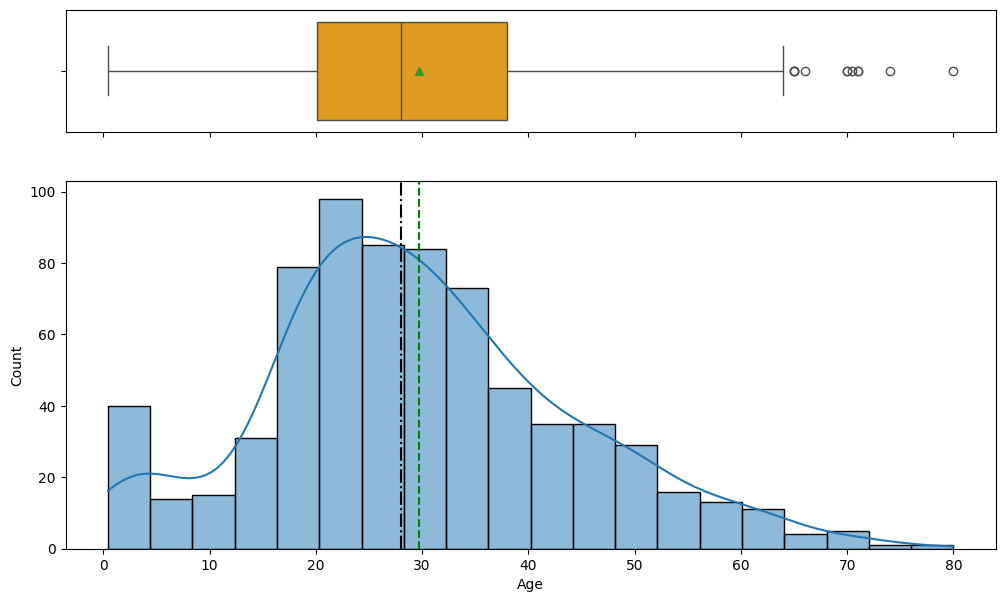

In [29]:
histogram_boxplot(titantrain,'Age', kde = True)

In [30]:
titantrain.loc[titantrain['Age'] < 1]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
78,79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S
469,470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,NaN,C
644,645,1,3,"Baclini, Miss. Eugenie",female,0.75,2,1,2666,19.2583,NaN,C
755,756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S
803,804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,NaN,C
831,832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,NaN,S


Observations:
- There are a lot of passengers that are aged below 5
- There are a number of outliers that are aged above 60, but it is very possible for elderly passengers to be on the titanic.
- The mean age is around 29 years old
- The median age is around 28 years old

#### Siblings & Spouses

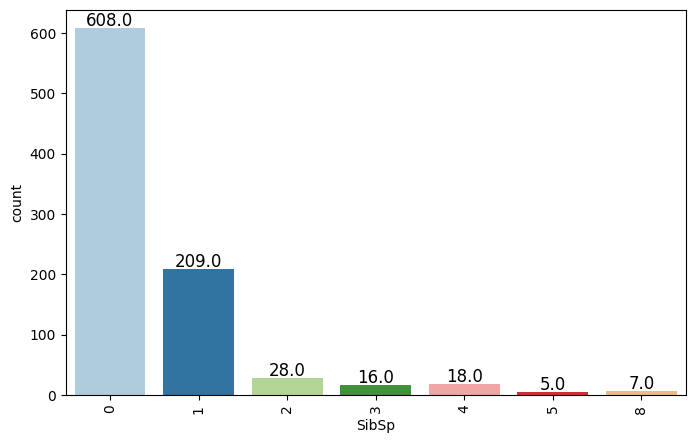

In [31]:
#Since the number of siblings and spouses are discrete values, we use the countplot to study this variable
labeled_countplot(titantrain,'SibSp', order = ['0','1','2','3','4','5','8'])

Observations:
- Majority of the passengers did not have siblings or spouses (68.2%)
- 23.5% of the passengers travelled with one sibling or spouse
- Only 7 people travelled with 8 siblings, which is weird as there should be 8 people identifying to be travelling with 8 SibSp

In [32]:
#See if there are any trends with the cluster that has 8 siblings
titantrain.loc[titantrain['SibSp'] == 8]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [33]:
#Since all the siblings contain the surname 'Sage', we can see if there are any other passengers with 'Sage' in their name
titantrain[titantrain['Name'].astype('string').str.contains("Sage")]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
641,642,1,1,"Sagesser, Mlle. Emma",female,24.0,0,0,PC 17477,69.30,B35,C
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [34]:
#It was also observed that all the siblings had the same ticket number, so we can see if anybody else had the same ticekt.
titantrain.loc[titantrain['Ticket'] == "CA. 2343"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


As there are no null values in the SibSp column, the last sibling may just have been excluded from this dataset, nothing out of the ordinary.

#### Parents or Cildren

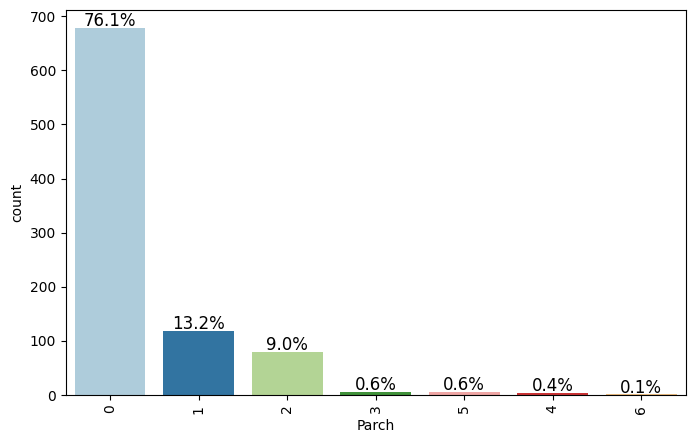

In [35]:
#Since the number of siblings and spouses are discrete values, we use the countplot to study this variable
labeled_countplot(titantrain,'Parch', perc = True)

Observations:
- 76% of the passengers are not travelling with parents or children
- Only one passenger is travelling with 6 children
- The trend seems natural, that there is lesser number of people traveling with more parents/children

#### Fare

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64


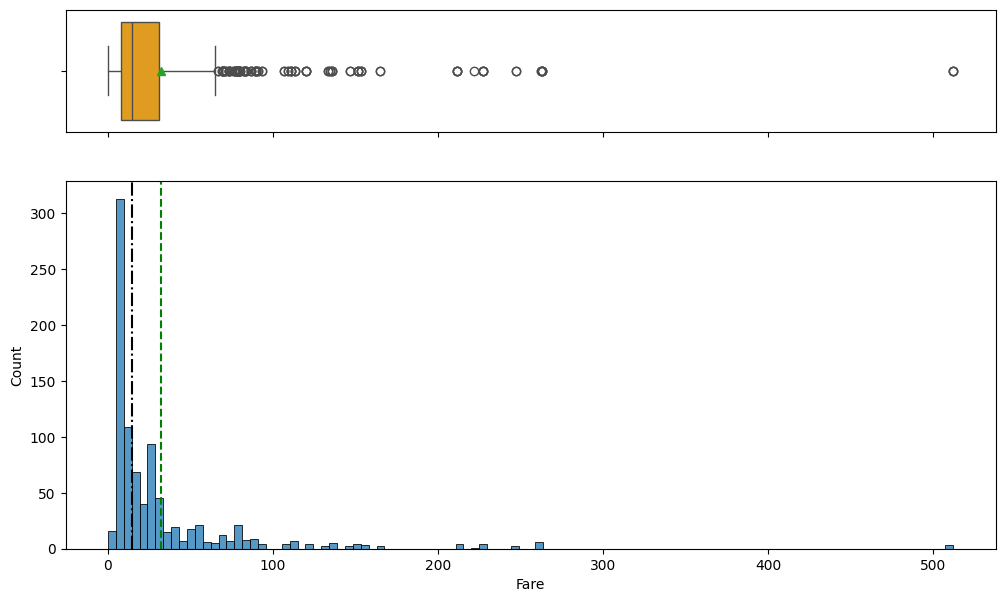

In [36]:
histogram_boxplot(titantrain,'Fare')

In [37]:
#Let's look at the top 10 most expensive tickets on the titanic, and see if 512 is a common price for the tickets
titantrain.sort_values(by = 'Fare', ascending = False).head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,C23 C25 C27,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.0000,C23 C25 C27,S
438,439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0000,C23 C25 C27,S
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C
742,743,1,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C


In [38]:
# The cheapest tickets are 0, which means the tickets are free. Let's take a look and see if that is normal
titantrain.loc[titantrain['Fare'] == 0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


Observations:

- It appears that the passengers who purchased the $512 tickets were from the same group, with the same ticket number of PC17755.
- There are also many passengers with free tickets, coming from all age and classes. All of the free tickets are male and come from Southampton.

Trivia: Based on research, it seems like Anna Ward and Gustave J Lesurer were both servants to thomas Drake Martinez

### Categorical Variables

#### Survived

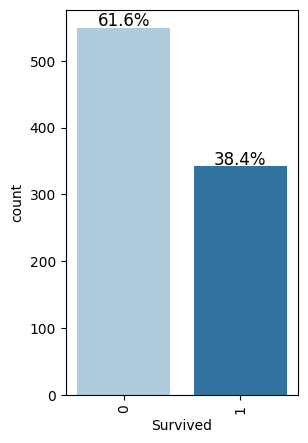

In [39]:
labeled_countplot(titantrain,'Survived',True)

Observations:
- Majority of the passengers did not survived the Titanic (62%)

#### Pclass

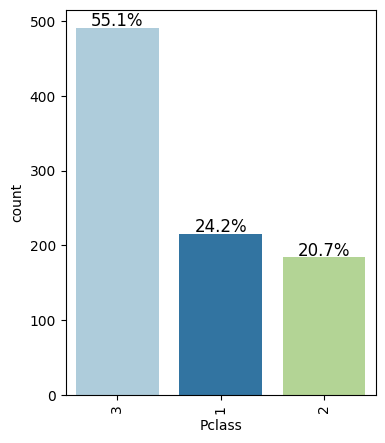

In [40]:
labeled_countplot(titantrain, 'Pclass',True)

Observations:
- More than half of the passengers are staying in the lower class (55%)
- There are more passengers staying in the upper class than the middle class, even though the normal distribution should be that there are lesser passengers in in the higher classes.

#### Sex

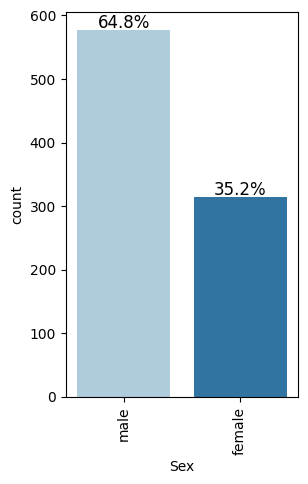

In [41]:
labeled_countplot(titantrain, 'Sex',True)

#### Tickets

Ticket is akin to Name, another identifier. But let's still look into the data to se if there is any pattern inside.

In [42]:
#Number of unique ticket numbers
titantrain['Ticket'].nunique()

681

In [43]:
#Which are the tickets with multiple counts?
titantrain['Ticket'].value_counts()

Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

In [44]:
#Why do these tickets have multiple counts?
titantrain.loc[titantrain['Ticket'] == '347082']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.275,NaN,S
119,120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.275,NaN,S
541,542,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.275,NaN,S
542,543,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.275,NaN,S
610,611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.275,NaN,S
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.275,NaN,S
850,851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.275,NaN,S


Observations:
- It appears that if a group or family buys multiple tickets together, that single transaction is considered one unique ticket.
- Another thing to note is that the tickets sometimes include letters, and can have different length of numbers.

#### Cabin

In [45]:
nullcount = round(titantrain['Cabin'].isna().sum()/len(titantrain)*100,2)
print(f'{nullcount}% of data is null!')

77.1% of data is null!


In [46]:
titantrain['Cabin'].value_counts()

Cabin
B96 B98            4
G6                 4
C23 C25 C27        4
C22 C26            3
F33                3
F2                 3
E101               3
D                  3
C78                2
C93                2
E8                 2
D36                2
B77                2
C123               2
E121               2
E44                2
D35                2
C125               2
E67                2
B35                2
B18                2
E24                2
B49                2
C65                2
B20                2
B5                 2
B57 B59 B63 B66    2
C126               2
B51 B53 B55        2
F4                 2
C124               2
F G73              2
B58 B60            2
C52                2
D33                2
C68                2
D20                2
D26                2
B28                2
C83                2
E25                2
D17                2
B22                2
C92                2
C2                 2
E33                2
C70                1
E58    

Observations:
- the cabin number is made up of alphabets and numbers.
- 77% of the data is missing

The alphabet indicates the deck layer, and the numbers indicate the location of the cabin on the floor. So we can separate this column into the alphabets and the numbers to further understand if the location of the cabin on the Titanic will influence the survival rate

In [47]:
# Extract alphabets from cabin and categorize them into single alphabets
titantrain['cabin_alphabet'] = titantrain['Cabin'].str.extractall(r'([A-Za-z]+)').groupby(level=0)[0].apply(lambda x: ','.join(x))
titantrain['cabin_alphabet'] = titantrain['cabin_alphabet'].str.split(',').str[0]

#Extract numbers from cabin and obtaining the mean of the passengers with multiple rooms
titantrain['cabin_numbers'] = titantrain['Cabin'].str.extractall(r'(\d+)').groupby(level=0)[0].agg(list).apply(lambda x: sum(map(int, x)) / len(x)).astype(int)

In [48]:
titantrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     891 non-null    object 
 1   Survived        891 non-null    object 
 2   Pclass          891 non-null    object 
 3   Name            891 non-null    object 
 4   Sex             891 non-null    object 
 5   Age             714 non-null    float64
 6   SibSp           891 non-null    int64  
 7   Parch           891 non-null    int64  
 8   Ticket          891 non-null    object 
 9   Fare            891 non-null    float64
 10  Cabin           204 non-null    object 
 11  Embarked        889 non-null    object 
 12  cabin_alphabet  204 non-null    object 
 13  cabin_numbers   200 non-null    float64
dtypes: float64(3), int64(2), object(9)
memory usage: 97.6+ KB


In [49]:
titantrain['cabin_alphabet'].value_counts()

cabin_alphabet
C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: count, dtype: int64

**Cabin Alphabets**

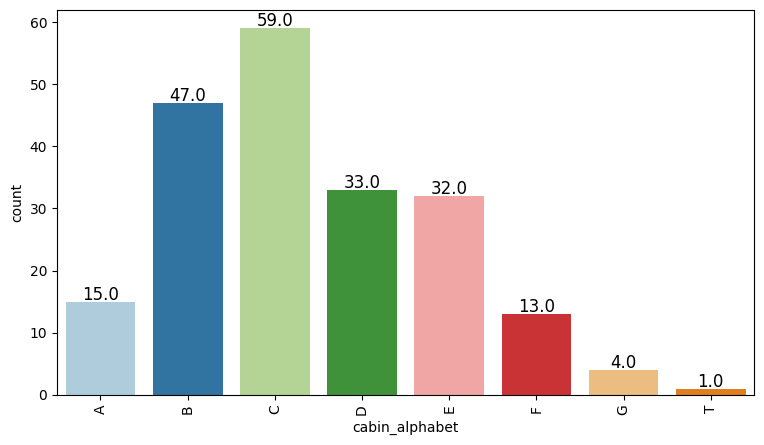

In [50]:
labeled_countplot(titantrain, 'cabin_alphabet', order = ['A','B','C','D','E','F','G','T'])

Observations:
- Deck C has the most passengers, followed by B, D and E
- There are lesser passengers staying in the upper and lower decks
- There is one person staying in deck 'T', which does not fit the alphabetical order of the cabin number
- The distribution of the cabin is slightly skewed to the right
- The total number of cabins is much lesser than the actual distribution, so this distribution might not be accurate


**Cabin Numbers**

count    200.000000
mean      50.665000
std       35.380527
min        2.000000
25%       24.000000
50%       43.000000
75%       77.250000
max      148.000000
Name: cabin_numbers, dtype: float64


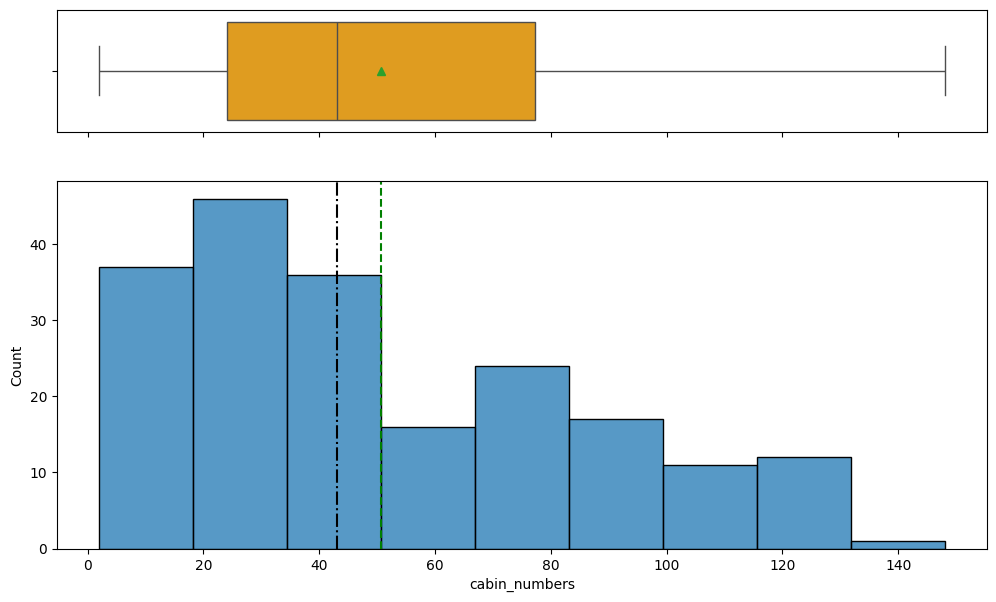

In [51]:
histogram_boxplot(titantrain, 'cabin_numbers')

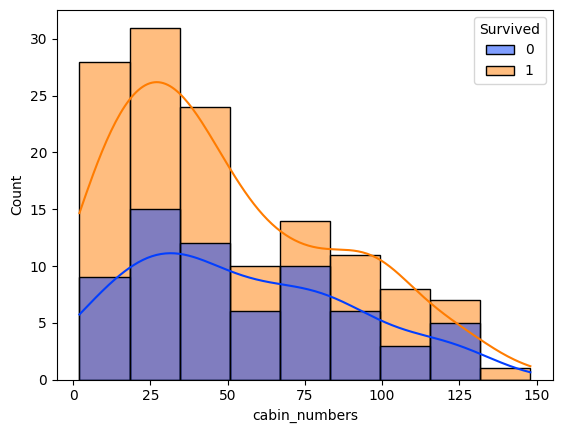

In [52]:
g = sns.histplot(data = titantrain, x = 'cabin_numbers', hue = 'Survived', kde = True, palette = 'bright')
g.xaxis.set_major_locator(ticker.MultipleLocator(25))

Observations:
- It appears that there may be 2 bigger groups of cabins:
 - 0 - 75
 - 76 - 150
- There is also more passengers staying in the lower numbers, indicating that the location of the rooms with the smaller numbers are more common.
- From the KDE plot, there is a much higher rate of survival if your number is between 0 - 75

#### Embarked

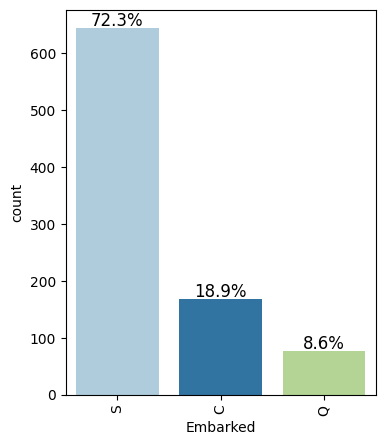

In [53]:
labeled_countplot(titantrain, 'Embarked',True)

Observations:
- 72% of the passengers came from Southampton
- There are 2 outliers

## Multivariate Analysis

### Numerical Variables

<Axes: >

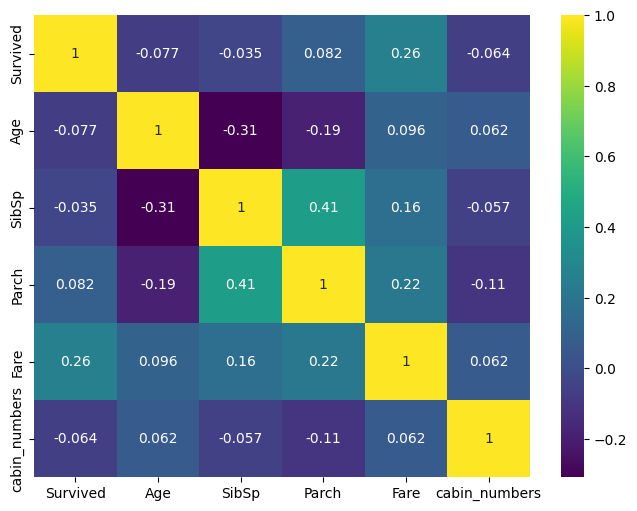

In [54]:
titantrain['Survived'] = titantrain['Survived'].astype('int')
plt.figure(figsize = (8,6))
sns.heatmap(titantrain.corr(numeric_only = True), annot = True, cmap = 'viridis')

Observations:
- There is a positive relationship between the price of the ticket and the survival rate
- There is a slight negative relationship between Age and Survival rate
- There is also a slight negative relationship between survival rate and the presence of siblings and spouses.

### Does the Deck layer affect the survival rate?

<Axes: xlabel='cabin_alphabet', ylabel='count'>

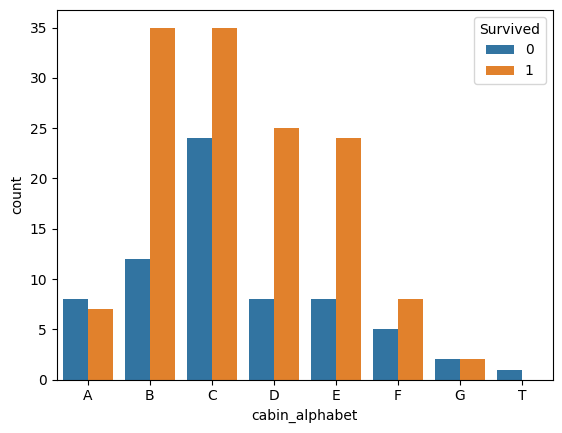

In [55]:
sns.countplot(x = titantrain['cabin_alphabet'], hue = titantrain['Survived'], order = ['A','B','C','D','E','F','G','T'])

Observations:
- Passengers in deck B and C have the highest survival rate.
- There are more passengers that have survived than passengers that have died in deck D to F
- Deck G has equal death and survival rate.
- More passengers died in deck A than thos that survived.
- This data is not representative right now, as there should be more passengers that have died overall, as discovered in univariate analysis of the survival frequency. Therefore we can say that this distribution is not accurate right now due to the significant null values.
- However, it is possible that deck B and C had the easiest and fastest access to the lifeboats, resulting in the much higher survival rate

### Does gender affect survival?

<Axes: xlabel='Sex', ylabel='count'>

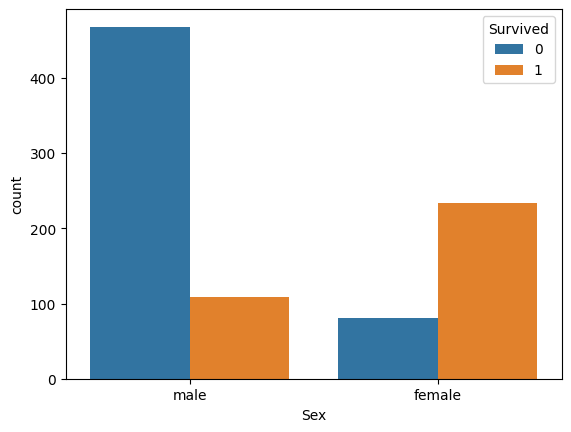

In [56]:
sns.countplot(x = titantrain['Sex'], hue = titantrain['Survived'])

Observations:
- It is very clear from this chart being a female dramatically increases the survival rate.

### How does age affect the survival rate?

<Axes: xlabel='Age', ylabel='Density'>

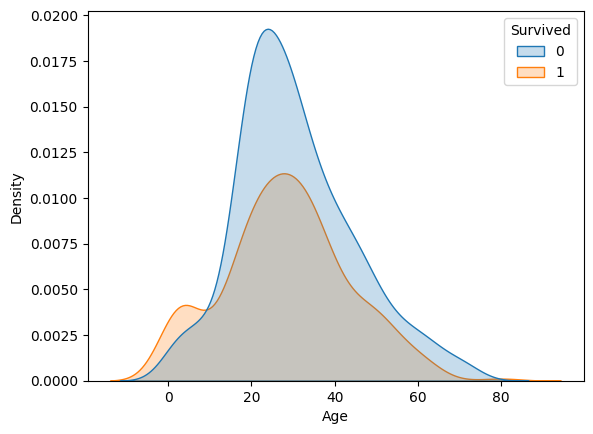

In [57]:
sns.kdeplot(titantrain, x = 'Age', hue = 'Survived', shade = True)

Observations:
- Aha! The children have a higher survival rate

### Does Age in different gender affect the survival rate?

<Axes: xlabel='Sex', ylabel='Age'>

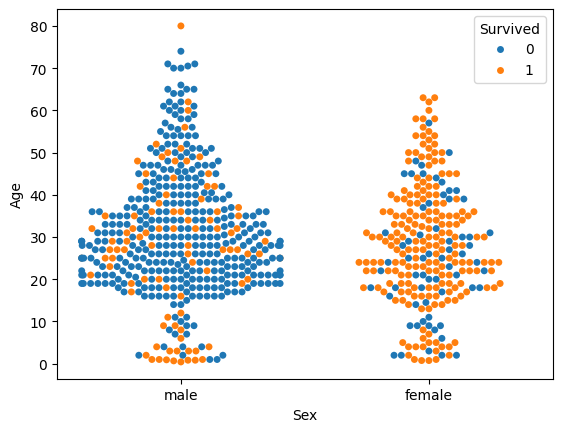

In [58]:
sns.swarmplot(titantrain, x ='Sex', y = 'Age', hue = 'Survived')

Observations:
- Generally, being female will have a higher survival rate on the titanic.
- It can also be seen that male children have a higher survival rate as compared to that of adult males.

### Do people in the higher classes have higher chance of survival?

Survived    0    1  All
Pclass                 
All       549  342  891
1          80  136  216
3         372  119  491
2          97   87  184
------------------------------------------------------------------------------------------------------------------------


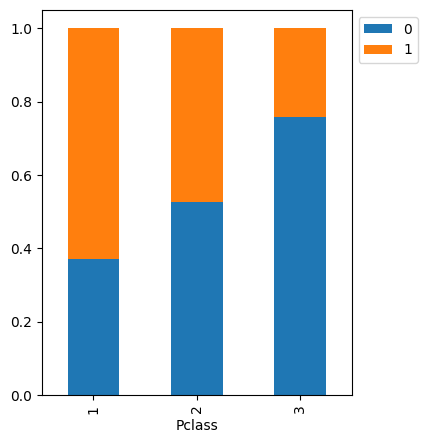

In [59]:
stacked_barplot(titantrain,'Pclass','Survived')

Observations:
- Indeed a higher class means you have a higher chance of survival. The percentage of survivors decreases with the class.

### Does age matter in different class?

<Axes: xlabel='Pclass', ylabel='Age'>

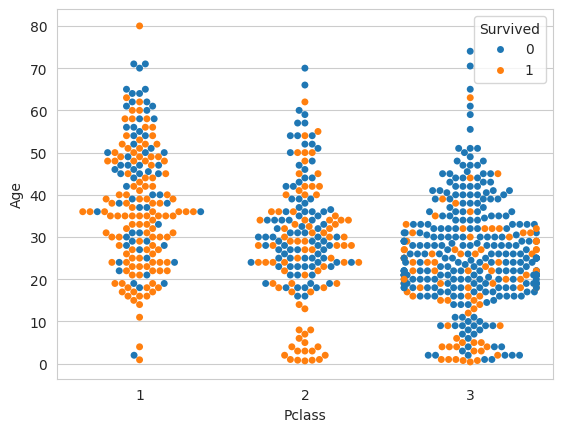

In [60]:
sns.set_style("whitegrid")
sns.swarmplot(titantrain, x = 'Pclass', y = 'Age', hue = 'Survived')

In [61]:
titantrain.loc[(titantrain['Survived'] == 1) & (titantrain['Pclass'] == 1)].sort_values(by='Age',ascending = True)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cabin_alphabet,cabin_numbers
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,C,24.0
445,446,1,1,"Dodge, Master. Washington",male,4.00,0,2,33638,81.8583,A34,S,A,34.0
802,803,1,1,"Carter, Master. William Thornton II",male,11.00,1,2,113760,120.0000,B96 B98,S,B,97.0
435,436,1,1,"Carter, Miss. Lucile Polk",female,14.00,1,2,113760,120.0000,B96 B98,S,B,97.0
689,690,1,1,"Madill, Miss. Georgette Alexandra",female,15.00,0,1,24160,211.3375,B5,S,B,5.0
504,505,1,1,"Maioni, Miss. Roberta",female,16.00,0,0,110152,86.5000,B79,S,B,79.0
853,854,1,1,"Lines, Miss. Mary Conover",female,16.00,0,1,PC 17592,39.4000,D28,S,D,28.0
329,330,1,1,"Hippach, Miss. Jean Gertrude",female,16.00,0,1,111361,57.9792,B18,C,B,18.0
307,308,1,1,"Penasco y Castellana, Mrs. Victor de Satode (M...",female,17.00,1,0,PC 17758,108.9000,C65,C,C,65.0
550,551,1,1,"Thayer, Mr. John Borland Jr",male,17.00,0,2,17421,110.8833,C70,C,C,70.0


Observations:
- You do have a lower survival rate when you are in 3rd class.
- But even in the third class, you still have a higher survival rate if you are a child age 5 or lower.

### Does gender matter if you paid higher prices?

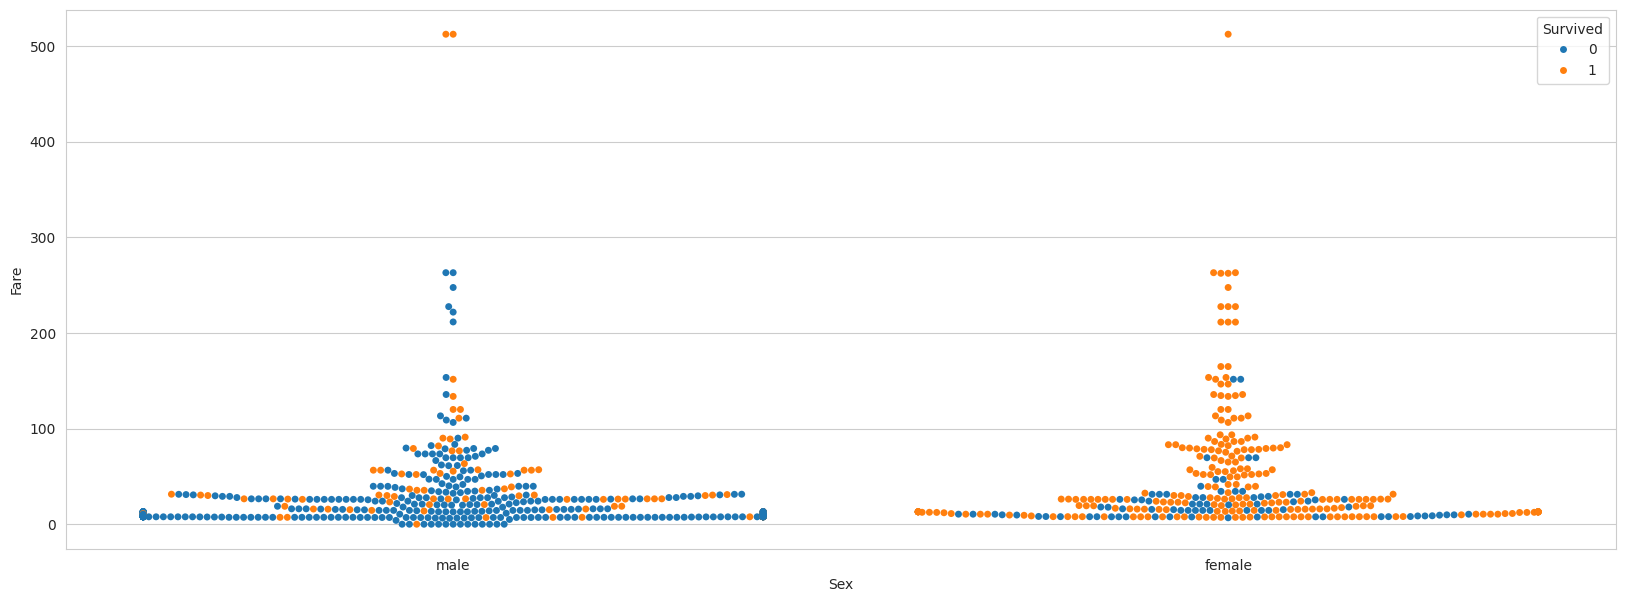

In [62]:
plt.figure(figsize = (20,7))
sns.swarmplot(titantrain, x='Sex', y='Fare', hue = 'Survived');

Observations:
- The survival rate does increase with higher ticket fare in both male and female.
- However, if a male passenger paid between 200 to 300 for the tickets, the survival rate is 0%
- Those who paid more than 500 all survived.

### Can we use anything to approximate the missing cabin numbers?

Embarked         C  Q    S  All
cabin_alphabet                 
All             69  4  129  202
C               21  2   36   59
E                5  1   26   32
F                1  1   11   13
A                7  0    8   15
B               22  0   23   45
D               13  0   20   33
G                0  0    4    4
T                0  0    1    1
------------------------------------------------------------------------------------------------------------------------


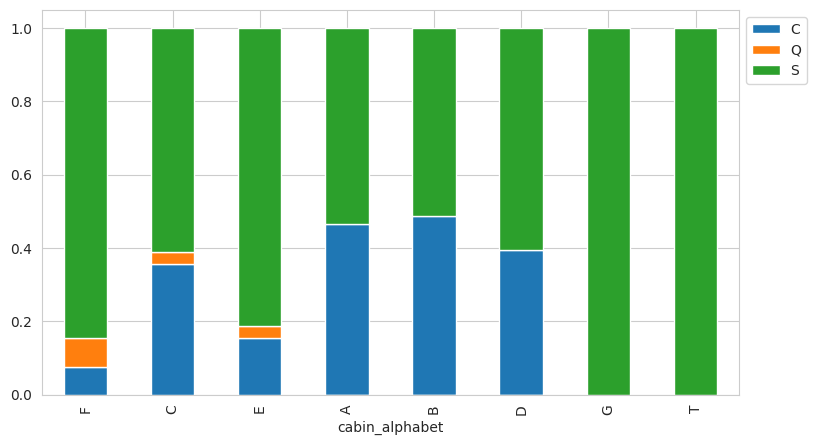

In [63]:
stacked_barplot(titantrain,'cabin_alphabet','Embarked')

Pclass            1   2   3  All
cabin_alphabet                  
All             176  16  12  204
F                 0   8   5   13
D                29   4   0   33
E                25   4   3   32
A                15   0   0   15
B                47   0   0   47
C                59   0   0   59
G                 0   0   4    4
T                 1   0   0    1
------------------------------------------------------------------------------------------------------------------------


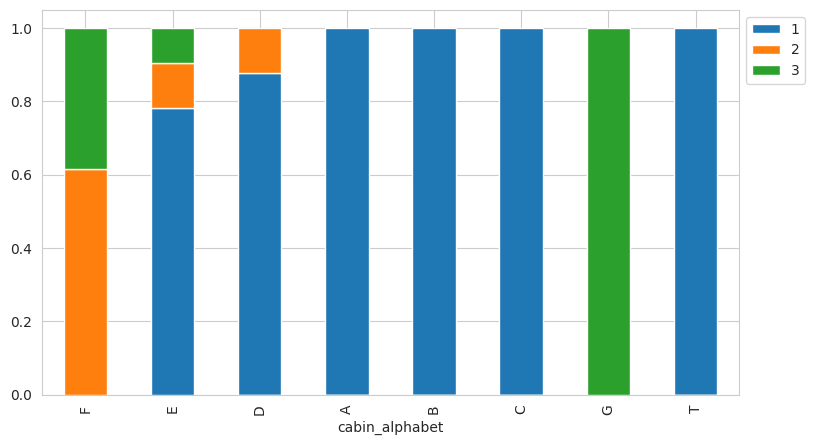

In [64]:
stacked_barplot(titantrain,'cabin_alphabet','Pclass')

Survived         0    1  All
cabin_alphabet              
All             68  136  204
B               12   35   47
C               24   35   59
D                8   25   33
E                8   24   32
F                5    8   13
A                8    7   15
G                2    2    4
T                1    0    1
------------------------------------------------------------------------------------------------------------------------


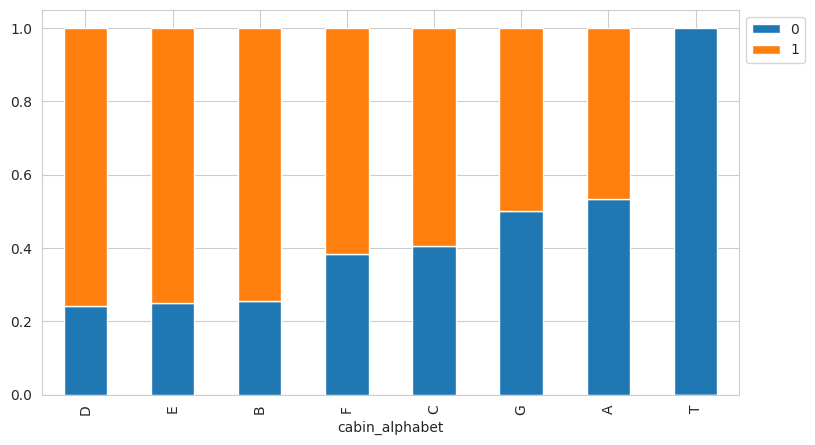

In [65]:
stacked_barplot(titantrain,'cabin_alphabet','Survived')

Observations:
- There are 10 times more 1st class passengers than 2nd or 3rd class passengers in the remaining data that still has cabin values. This is unrepresentative of the distribution of passengers across the classes.

Using Fare to estimate cabin

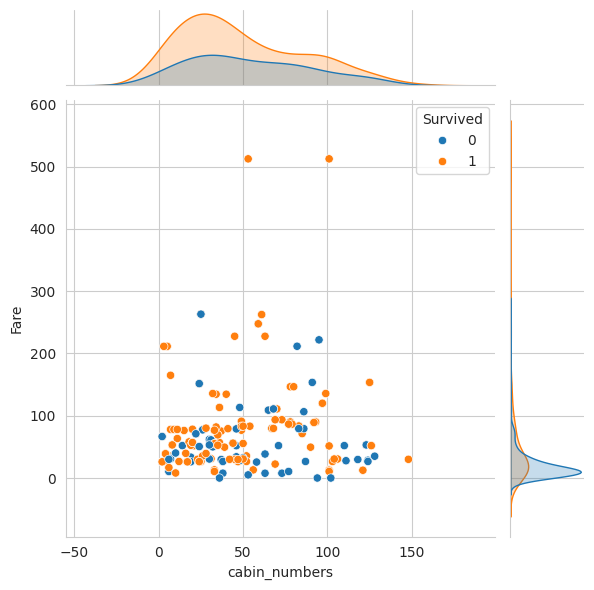

In [66]:
sns.jointplot(data = titantrain, x = 'cabin_numbers', y = 'Fare',hue = 'Survived')

<Axes: xlabel='cabin_alphabet', ylabel='Fare'>

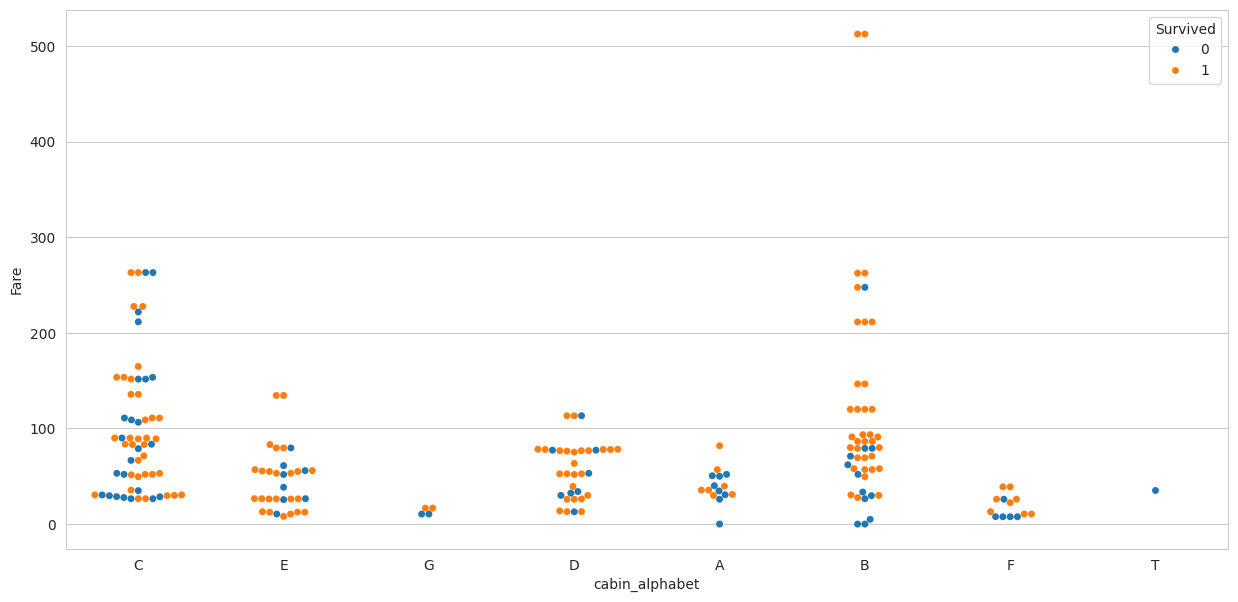

In [67]:
plt.figure(figsize = (15,7))
sns.swarmplot(data = titantrain, x = 'cabin_alphabet', y = 'Fare', hue = 'Survived')

Conclusion:
- Because the remaining data from cabin is so scarce, it is very difficult to substitute the data.
- It can be seen that Fare is a much better estimate for survival rate than the cabin number or letter. For example, cabin B and C have much higher survival rate, but their prices extends to a higher range.
- As cabin also has a very high amount of missing value in the test data, it could be wiser to just drop this column.

# Feature Engineering

##Family Size

Since the idea of having children, spouse, parents or child are quite similar, we can combine these features into one feature where we count the size of the family.

In [68]:
titantrain['family'] = titantrain['SibSp'] + titantrain['Parch'] + 1

In [69]:
titantrain['family'].value_counts()

family
1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: count, dtype: int64

wait there are some crazy high numbers, lets take a look at what they are

In [70]:
titantrain.loc[titantrain['family']> 8]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cabin_alphabet,cabin_numbers,family
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S,NaN,NaN,11
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S,NaN,NaN,11
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S,NaN,NaN,11
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S,NaN,NaN,11
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S,NaN,NaN,11
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S,NaN,NaN,11
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S,NaN,NaN,11


Okay, they are just one big family, with 2 parents and 8 siblings. Nothing out of ordinary

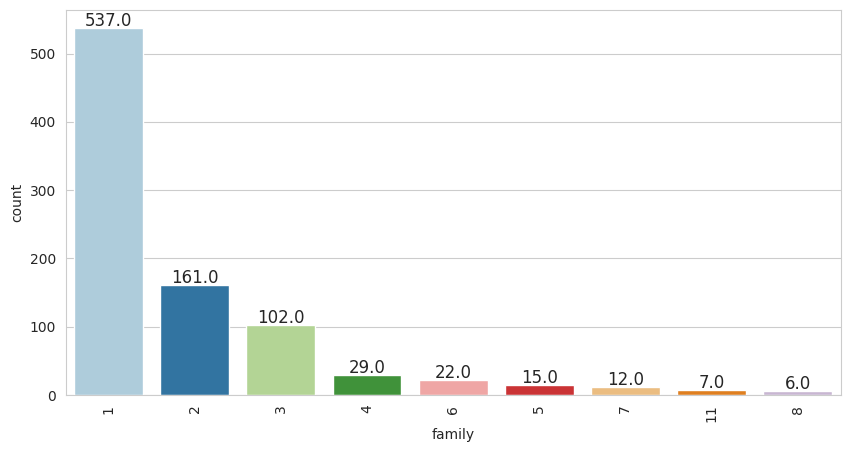

In [71]:
labeled_countplot(titantrain,'family')

<Axes: xlabel='family', ylabel='count'>

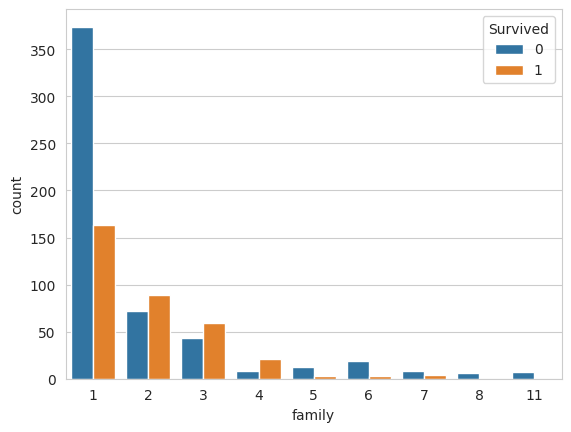

In [72]:
sns.countplot(data = titantrain, x = 'family', hue = 'Survived')

Observations:
- The distribution of the family size is skewed towards the right.
- Seems like passengers who are travelling solo has quite low survival rate as compared to the passengers with 2 to 4 family members.
- With a family size of 5 and above, the survival rate plummets.

## Ticketing Alphabet, Numbers and Length

Let's break down the tickets into ticket number, alphabets and length to understand more about the ticketing system

In [73]:
# Extract alphabets from Ticket and categorize them into single alphabets
titantrain['ticket_alphabet'] = titantrain['Ticket'].str.extractall(r'([A-Za-z]+)').groupby(level=0)[0].apply(lambda x: ','.join(x))
titantrain['ticket_alphabet'] = titantrain['ticket_alphabet'].str.split(',').str[0]

#Extract numbers from Ticket and obtaining the ticket number of the passengers with multiple rooms
titantrain['ticket_numbers'] = titantrain['Ticket'].str.extractall(r'(\d+)').groupby(level=0).agg(lambda x: x.iloc[-1]) #Some ticket numbers have multiple segments of numerical values due to the alphabet portion. So we take only the last segment.
titantrain['ticket_numbers'] = titantrain['ticket_numbers'].apply(lambda x: int(x) if pd.notnull(x) else 0)

#Extract the length of the ticket number
titantrain['ticket_length'] = titantrain['ticket_numbers'].apply(lambda x:len(str(x)) if pd.notnull(x) else 0)

### **Ticket Alphabet**

In [74]:
#Seeing what the alphabets look like
titantrain['ticket_alphabet'].value_counts()

ticket_alphabet
PC       60
C        33
A        29
STON     18
SOTON    17
S        14
CA       14
SC       13
W        11
F         6
LINE      4
PP        3
P         2
WE        2
SO        1
Fa        1
SW        1
SCO       1
Name: count, dtype: int64

In [75]:
#Seeing if the alphabets is related to the source of embarkation
titantrain.groupby(['Embarked'])['ticket_alphabet'].value_counts()

Embarked  ticket_alphabet
C         PC                 46
          SC                 11
          P                   2
          S                   2
Q         A                   1
S         C                  33
          A                  28
          STON               18
          SOTON              17
          PC                 14
          CA                 14
          S                  12
          W                  11
          F                   6
          LINE                4
          PP                  3
          SC                  2
          WE                  2
          SCO                 1
          SO                  1
          Fa                  1
          SW                  1
Name: count, dtype: int64

Observations:
- Seems like PC could be Port Cherbourg, as majority of tickets that embarked from Cherbourg has PC on it. However, we can see that some of the tickets from Southampton also has PC.
- There are also many letters in each embarkation location that has no strong pattern that can be useful for us.
- **This feature can be dropped out**

### **Ticket Numbers**

In [76]:
titantrain['ticket_numbers'].value_counts().sort_index(ascending = False)

ticket_numbers
3101317    1
3101316    1
3101312    1
3101311    1
3101310    1
          ..
695        1
693        1
541        1
3          2
0          4
Name: count, Length: 679, dtype: int64

<Axes: xlabel='ticket_numbers', ylabel='Count'>

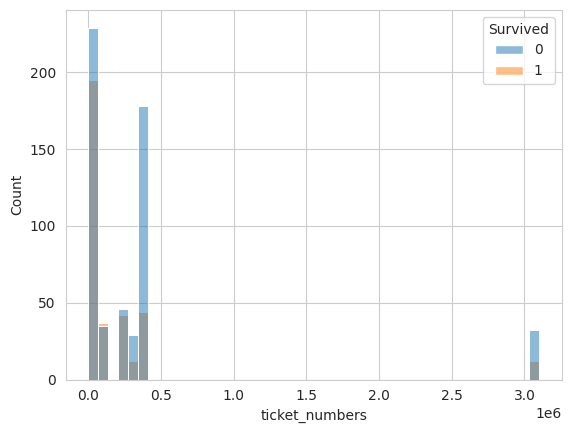

In [77]:
sns.histplot(data = titantrain, x = 'ticket_numbers', hue = 'Survived')

Observations:
- Chance of surviving is higher at lower numbers?!
- There are like 3 groups of ticket numbers allocated, one is smaller than 200,000, other is from 200,000 to 400,000, then the last group is larger than 3,000,000.

### **Ticket Length**

In [78]:
titantrain.sort_values(by = 'ticket_length')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cabin_alphabet,cabin_numbers,family,ticket_alphabet,ticket_numbers,ticket_length
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0000,NaN,S,NaN,NaN,1,LINE,0,1
772,773,0,2,"Mack, Mrs. (Mary)",female,57.0,0,0,S.O./P.P. 3,10.5000,E77,S,E,77.0,1,S,3,1
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0000,NaN,S,NaN,NaN,1,LINE,0,1
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0000,NaN,S,NaN,NaN,1,LINE,0,1
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0000,NaN,S,NaN,NaN,1,LINE,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,143,1,3,"Hakkarainen, Mrs. Pekka Pietari (Elin Matilda ...",female,24.0,1,0,STON/O2. 3101279,15.8500,NaN,S,NaN,NaN,2,STON,3101279,7
590,591,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,NaN,NaN,1,STON,3101273,7
371,372,0,3,"Wiklund, Mr. Jakob Alfred",male,18.0,1,0,3101267,6.4958,NaN,S,NaN,NaN,2,NaN,3101267,7
729,730,0,3,"Ilmakangas, Miss. Pieta Sofia",female,25.0,1,0,STON/O2. 3101271,7.9250,NaN,S,NaN,NaN,2,STON,3101271,7


<Axes: xlabel='ticket_length', ylabel='Density'>

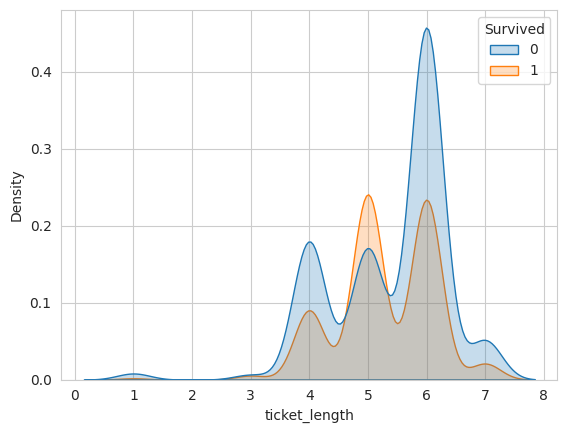

In [79]:
sns.kdeplot(data = titantrain, x = 'ticket_length', hue = 'Survived', shade = True)

<Axes: xlabel='ticket_length', ylabel='Density'>

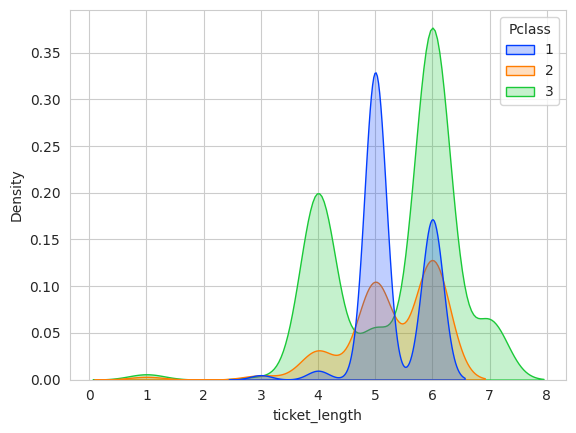

In [80]:
sns.kdeplot(data = titantrain, x = 'ticket_length', hue = 'Pclass', palette = 'bright', shade = True)

In [81]:
#Converting the datatype into categorical
titantrain['ticket_length'] = titantrain['ticket_length'].astype('object')

Observations:
- it is intersting to see that at a ticket length of 5, you have a higher chance to survive.
- It seems that many of the tickets with length of 5 belongs to the upper class
- As the length of the ticket number is not considered a continuous variable, this variable was converted into an object datatype

# Data Pre-Processing

## Null Value Treatment

### Estimate Free Tickets

In [82]:
# The class distribution of the free tickets
freetix = titantrain.loc[titantrain['Fare'] == 0]
freetix['Pclass'].value_counts()

Pclass
2    6
1    5
3    4
Name: count, dtype: int64

<Axes: xlabel='Pclass', ylabel='Fare'>

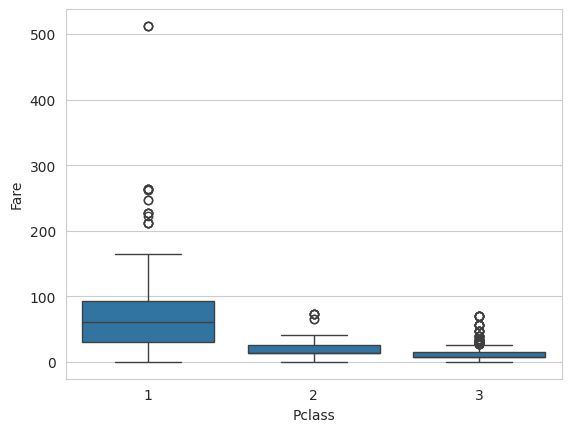

In [83]:
#Seeing if Fare is affected by the class
sns.boxplot(data = titantrain, x = 'Pclass', y = 'Fare')

<Axes: xlabel='Age', ylabel='Fare'>

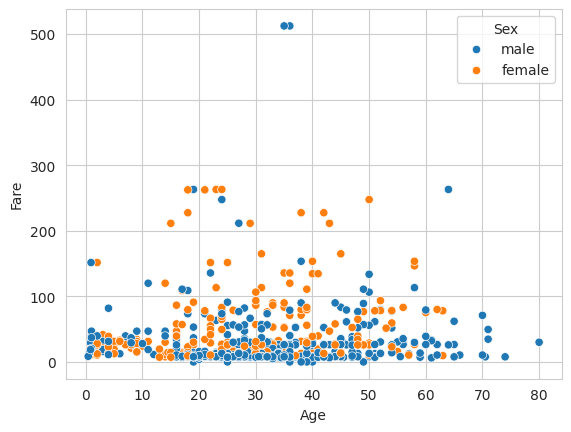

In [84]:
#Seeing if fare or age is affected by age
sns.scatterplot(data= titantrain, x = 'Age', y = 'Fare', hue = 'Sex')

Observations:
- It seems that Age or Sex does not affect fare.
- The class is a good estimator for the fare price. We can substitute all free tickets with the class specific medians.

As there are presence of very expensive tickets, using median might be more accurate.

In [85]:
#Obtain the median values of each group
medians = titantrain.groupby(['Pclass'])['Fare'].median()

#Let's see what the median values are
print(medians)

Pclass
1    60.2875
2    14.2500
3     8.0500
Name: Fare, dtype: float64


In [86]:
#Assign each median value into each group
median1 = medians.get(1)
median2 = medians.get(2)
median3 = medians.get(3)

#Replace the free tickets' prices with group specific medians
titantrain.loc[(titantrain['Pclass'] == 1) & (titantrain['Fare'] == 0), 'Fare'] = median1
titantrain.loc[(titantrain['Pclass'] == 2) & (titantrain['Fare'] == 0), 'Fare'] = median2
titantrain.loc[(titantrain['Pclass'] == 3) & (titantrain['Fare'] == 0), 'Fare'] = median3

### Embark

Since there are only 2 null values in 'Embarked' (0.22% of data), we can take a look at these data and see if there are any important trends



In [87]:
#Having a look at the null embarked passengers
no_embarked = titantrain.loc[titantrain['Embarked'].isnull()]
no_embarked

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cabin_alphabet,cabin_numbers,family,ticket_alphabet,ticket_numbers,ticket_length
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,B,28.0,1,NaN,113572,6
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,B,28.0,1,NaN,113572,6


In [88]:
#Checking if there are other passengers staying in the same cabin
titantrain.loc[titantrain['Cabin'] == 'B28']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cabin_alphabet,cabin_numbers,family,ticket_alphabet,ticket_numbers,ticket_length
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,B,28.0,1,NaN,113572,6
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,B,28.0,1,NaN,113572,6


Observations:
- These passengers are both from class 1.
- Both passengers survived.
- Both passengers are travelling by themselves.
- Both paid the same fare of 80
- There are no other passengers sharing th same cabin.
- Both are also

Although they can be easily substituted with the median value, I just wanted to make sure that they are not any special cases that can contribute to the model building.

In [89]:
#Simplest way is to substitute the null values with the median location
titantrain['Embarked'].value_counts().sort_values(ascending = False)

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [90]:
#Making sure that it is not rare for class 1 passengers to survive
titantrain.groupby(['Pclass'])['Survived'].value_counts()

Pclass  Survived
1       1           136
        0            80
2       0            97
        1            87
3       0           372
        1           119
Name: count, dtype: int64

In [91]:
#Making sure that their age is not rare for someone who survived.
titantrain.groupby(['Survived'])['Age'].mean()

Survived
0    30.626179
1    28.343690
Name: Age, dtype: float64

In [92]:
titantrain.groupby(['Pclass'])['Embarked'].value_counts()

Pclass  Embarked
1       S           127
        C            85
        Q             2
2       S           164
        C            17
        Q             3
3       S           353
        Q            72
        C            66
Name: count, dtype: int64

Observations:
- The median 'embarked' value is S
- One of the passengers is aged 62, much higher than the average age of the survivors.
- Since they are both from the first class, there's a high likelihood that they embarked from Southampton.

In [93]:
#Substituted the null values with S for SOuthampton
titantrain.loc[titantrain['Embarked'].isna(),'Embarked'] = 'S'

#Check if the null values were substituted
print("There are",titantrain['Embarked'].isnull().sum(),"null values in Embarked")

There are 0 null values in Embarked


### Age

As there is a significant number of null values in 'Age', it will be good to identify trends that leads to these values being null. We will then be able to substitute the null values more accurately instead of removing or blindly substituting the data.

Factors to consider:
- Pclass - It seems that in class 3, children below the age of 6 have a higher chance of survival. In class 2, below age of 15 has higher chance of survival. In class 1, the age doesn't seem to affect survivability. But it seems like there are very little children in class 1.
- Survived - Most children age 5 or below have a very high survivability. This is even more obvious when you are a 3rd class passenger.

Here are the conditions we will use to substitute the missing ages:

- If the passenger is from class 2 and survived, age 7
- If the passenger is from class 3 and survived, age 2.5
- Every other passenger can be substituted with the median age.




In [94]:
#See what is the distribution of across the different combination of class and survival status
no_age = titantrain.loc[titantrain['Age'].isnull()]
no_age.groupby(['Pclass'])['Survived'].value_counts()

Pclass  Survived
1       0            16
        1            14
2       0             7
        1             4
3       0           102
        1            34
Name: count, dtype: int64

In [95]:
#Defining the values to be substituted according to the conditions
child2 = 14/2 # Class 2 childrens
child3 = 5/2 # Class 3 Childrens' age
median_age = titantrain['Age'].median() # The rest of the passengers with no age

# Substitution of null ages
titantrain.loc[(titantrain['Pclass']) == 3 & (titantrain['Survived'] == 1) & (titantrain['Age'].isnull()), 'Age'] = child3
titantrain.loc[(titantrain['Pclass']) == 2 & (titantrain['Survived'] == 1) & (titantrain['Age'].isnull()), 'Age'] = child2
titantrain.loc[titantrain['Age'].isnull(), 'Age'] = median_age

In [96]:
#Checking if there are still any null values in Age
titantrain['Age'].isnull().sum()

0

### Cabin

As we have uncovered that cabin is not representative of the population, and there were no other clues we can use to estimate the values, we have decided to drop the column all together.

## Dependent and Independent Variables of Interest

In [97]:
titantrain.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cabin_alphabet,cabin_numbers,family,ticket_alphabet,ticket_numbers,ticket_length
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,NaN,NaN,2,A,21171,5


In [98]:
#Dependent Variable of interest
y = titantrain['Survived']

#Independent variables
features = ['Pclass',
            'Sex',
            'Age',
            'Fare',
            'Embarked',
            'family',
            'ticket_numbers',
            'ticket_length']

x = titantrain[features]
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Pclass          891 non-null    object 
 1   Sex             891 non-null    object 
 2   Age             891 non-null    float64
 3   Fare            891 non-null    float64
 4   Embarked        891 non-null    object 
 5   family          891 non-null    int64  
 6   ticket_numbers  891 non-null    int64  
 7   ticket_length   891 non-null    object 
dtypes: float64(2), int64(2), object(4)
memory usage: 55.8+ KB


## Encoding Categorical Variables

In [99]:
#Performing one-hot encoding for the categorical variables
x = pd.get_dummies(x,
                   columns = x.select_dtypes(include = ["object","category"]).columns.tolist(),
                   drop_first = True, dtype = int)

In [100]:
x.head(1)

,Age,Fare,family,ticket_numbers,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,ticket_length_3,ticket_length_4,ticket_length_5,ticket_length_6,ticket_length_7
0,22.0,7.25,2,21171,0,1,1,0,1,0,0,1,0,0


## Split and Scale Data

In [101]:
# Splitting the dataset into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = True, random_state = 1)

In [102]:
print("Shape of Training set : ", x_train.shape)
print("Shape of test set : ", x_test.shape)

Shape of Training set :  (712, 14)
Shape of test set :  (179, 14)


In [103]:
# Scaling the data
sc=StandardScaler()

# Fit_transform on train data
x_train_scaled=sc.fit_transform(x_train)
x_train_scaled=pd.DataFrame(x_train_scaled, columns=x.columns)

# Transform on test data
x_test_scaled=sc.transform(x_test)
x_test_scaled=pd.DataFrame(x_test_scaled, columns=x.columns)

## Pre-processing Test Data

In [104]:
titantest.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Feature Engineering and Null Value Treatment

In [105]:
## Changing datatypes
titantest['Pclass'] = titantest['Pclass'].astype('object')

## Free Tickets
#Replace the free and null tickets' prices with group specific medians
titantest.loc[(titantest['Pclass'] == 1) & ((titantest['Fare'] == 0) | (titantest['Fare'].isna())), 'Fare'] = median1
titantest.loc[(titantest['Pclass'] == 2) & ((titantest['Fare'] == 0) | (titantest['Fare'].isna())), 'Fare'] = median2
titantest.loc[(titantest['Pclass'] == 3) & ((titantest['Fare'] == 0) | (titantest['Fare'].isna())), 'Fare'] = median3

print('Free Tickets Substituted with class specific medians')

## Null Age

#Defining the values to be substituted according to the conditions
child2 = 14/2 # Class 2 childrens' age
child3 = 5/2 # Class 3 Childrens' age
median_age = titantest['Age'].median() # The rest of the passengers with no age

# Substitution of null ages
titantest.loc[(titantest['Pclass']) == 3 & (titantest['Age'].isnull()), 'Age'] = child3
titantest.loc[(titantest['Pclass']) == 2 & (titantest['Age'].isnull()), 'Age'] = child2
titantest.loc[titantest['Age'].isnull(), 'Age'] = median_age
print('Null ages substituted with class specific median age')

## Null Embarked values with Southampton

#Substituted the null values with S for Southampton
titantest.loc[titantest['Embarked'].isna(),'Embarked'] = 'S'

#Check if the null values were substituted
print("Null Embarked values substituted with Southampton")

## Ticket Feature Engineering

# Extract alphabets from Ticket and categorize them into single alphabets
titantest['ticket_alphabet'] = titantest['Ticket'].str.extractall(r'([A-Za-z]+)').groupby(level=0)[0].apply(lambda x: ','.join(x))
titantest['ticket_alphabet'] = titantest['ticket_alphabet'].str.split(',').str[0]

#Extract numbers from Ticket and obtaining the ticket number of the passengers with multiple rooms
titantest['ticket_numbers'] = titantest['Ticket'].str.extractall(r'(\d+)').groupby(level=0).agg(lambda x: x.iloc[-1])
titantest['ticket_numbers'] = titantest['ticket_numbers'].apply(lambda x: int(x) if pd.notnull(x) else 0)

#Extract the length of the ticket number
titantest['ticket_length'] = titantest['ticket_numbers'].apply(lambda x:len(str(x)) if pd.notnull(x) else 0)

#Converting the ticket_length datatype into categorical
titantest['ticket_length'] = titantest['ticket_length'].astype('object')

print('Ticket information split into alphabets, numbers and length')

## Family Size

titantest['family'] = titantest['SibSp'] + titantest['Parch'] + 1
print('sibsp and parch combined into family size')

Free Tickets Substituted with class specific medians
Null ages substituted with class specific median age
Null Embarked values substituted with Southampton
Ticket information split into alphabets, numbers and length
sibsp and parch combined into family size


In [106]:
test_x = titantest[features]

#Double check test data, see if there are still null values
test_x.isna().sum()

Pclass            0
Sex               0
Age               0
Fare              0
Embarked          0
family            0
ticket_numbers    0
ticket_length     0
dtype: int64

### One-hot Encoding

In [107]:
#Performing one-hot encoding for the categorical variables
test_x = pd.get_dummies(test_x,
                        columns = test_x.select_dtypes(include = ["object","category"]).columns.tolist(),
                        drop_first = True)

In [108]:
test_x.shape

(418, 14)

### Scale Data

In [109]:
# Scaling the data
sc=StandardScaler()

#Scale the data
test_x_scaled=sc.fit_transform(test_x)
test_x_scaled=pd.DataFrame(test_x_scaled, columns=test_x.columns)

In [110]:
#Label the data with the respective ID
test_x_scaled = test_x_scaled.join(titantest['PassengerId'])

#Print out to see what the scaled data look like
test_x_scaled

,Age,Fare,family,ticket_numbers,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,ticket_length_3,ticket_length_4,ticket_length_5,ticket_length_6,ticket_length_7,PassengerId
0,0.408718,-0.502509,-0.553443,0.132042,-0.534933,0.957826,0.755929,2.843757,-1.350676,-0.120678,-0.486504,-0.675608,1.133205,-0.199502,892
1,1.349905,-0.517379,0.105643,0.187173,-0.534933,0.957826,-1.322876,-0.351647,0.740370,-0.120678,-0.486504,-0.675608,1.133205,-0.199502,893
2,2.479329,-0.469183,-0.553443,-0.022366,1.869391,-1.044031,0.755929,2.843757,-1.350676,-0.120678,-0.486504,-0.675608,1.133205,-0.199502,894
3,-0.155994,-0.487565,-0.553443,0.105198,-0.534933,0.957826,0.755929,-0.351647,0.740370,-0.120678,-0.486504,-0.675608,1.133205,-0.199502,895
4,-0.532469,-0.422555,0.764728,4.851741,-0.534933,0.957826,-1.322876,-0.351647,0.740370,-0.120678,-0.486504,-0.675608,-0.882453,5.012484,896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,-0.155994,-0.498549,-0.553443,-0.426193,-0.534933,0.957826,0.755929,-0.351647,0.740370,-0.120678,2.055480,-0.675608,-0.882453,-0.199502,1305
414,0.747545,1.310057,-0.553443,-0.401453,-0.534933,-1.044031,-1.322876,-0.351647,-1.350676,-0.120678,-0.486504,1.480149,-0.882453,-0.199502,1306
415,0.709898,-0.512896,-0.553443,4.851679,-0.534933,0.957826,0.755929,-0.351647,0.740370,-0.120678,-0.486504,-0.675608,-0.882453,5.012484,1307
416,-0.155994,-0.498549,-0.553443,0.180422,-0.534933,0.957826,0.755929,-0.351647,0.740370,-0.120678,-0.486504,-0.675608,1.133205,-0.199502,1308


# Deep Learning Models

## Metric Functions

In [111]:
# Creating metric function for Classifiers
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))

    #In this heatmap, make sure the xticklabels are labelled correctly in the format [label if prediction is 0, label if prediction is 1]. In this case, 1 means Satisfied, and 0 means Not Satisfied.
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Died', 'Survived'], yticklabels=['Died', 'Survived'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

## Basic Model: Adamax, Relu, Single Hidden Layer

### Build Model

In [7]:
# Fixing the seed for random number generators
np.random.seed(42)

import random
random.seed(42)

tf.random.set_seed(42)

In [8]:
# Initialize sequential model
# model_1 = tf.keras.Sequential([tf.keras.layers.Flatten(input_shape=(14,)),#Input layer, 14 parameters
#                                tf.keras.layers.Dense(64, activation='relu'), #Hidden layer
#                                tf.keras.layers.Dense(1, activation='sigmoid')]) #Output layer, only 1 node because we only have 1 result to predict

# Initializing the ANN
model_1 = Sequential()
model_1.add(Dense(activation = 'relu', input_dim = 14, units=64))
model_1.add(Dense(1, activation = 'sigmoid'))

In [9]:
#Using the settings for the sequential model above, create the model with the following algorithms
model_1.compile(loss = 'binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

#Show the model summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                960       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
_________________________________________________________________


In [112]:
# Let us now fit the model onto our data
history1 = model_1.fit(x_train_scaled,
                          y_train,
                          validation_split=0.2, #20% for validation data
                          verbose=1, #It writes the verbiage for the training progress. A higher number would give more information
                          epochs=50, #Number of times the model goes through the entire training dataset
                          batch_size=32) #This is the batch Stochastic Gradient Descend method, with batchsize per training step

Epoch 1/50
18/18 [==============================] - 3s 43ms/step - loss: 0.6525 - accuracy: 0.6309 - val_loss: 0.6388 - val_accuracy: 0.6573
Epoch 2/50
18/18 [==============================] - 0s 13ms/step - loss: 0.5712 - accuracy: 0.7417 - val_loss: 0.5693 - val_accuracy: 0.6713
Epoch 3/50
18/18 [==============================] - 0s 9ms/step - loss: 0.5204 - accuracy: 0.7979 - val_loss: 0.5232 - val_accuracy: 0.7692
Epoch 4/50
18/18 [==============================] - 0s 13ms/step - loss: 0.4865 - accuracy: 0.8260 - val_loss: 0.4911 - val_accuracy: 0.7832
Epoch 5/50
18/18 [==============================] - 0s 17ms/step - loss: 0.4629 - accuracy: 0.8330 - val_loss: 0.4686 - val_accuracy: 0.7902
Epoch 6/50
18/18 [==============================] - 1s 43ms/step - loss: 0.4447 - accuracy: 0.8366 - val_loss: 0.4535 - val_accuracy: 0.7972
Epoch 7/50
18/18 [==============================] - 1s 35ms/step - loss: 0.4307 - accuracy: 0.8383 - val_loss: 0.4429 - val_accuracy: 0.7972
Epoch 8/50
18/

### Model Accuracy and Loss with Epochs

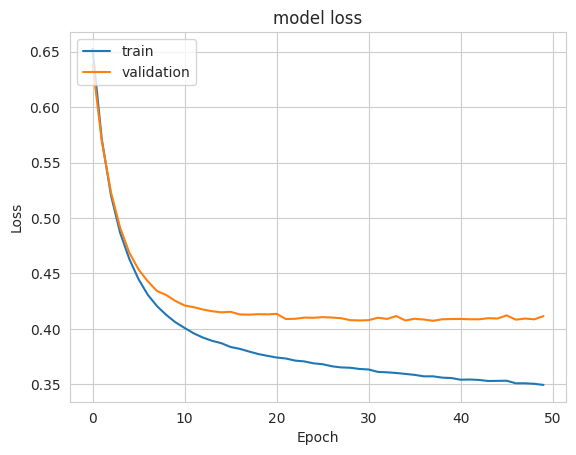

In [113]:
#Plotting Train Loss vs Validation Loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

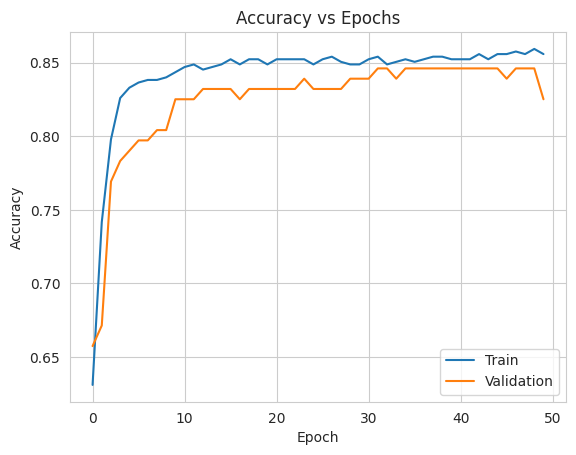

In [114]:
#Plotting Epoch vs accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])

plt.title('Accuracy vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

Observations:
- The accuracy of the model on validation dataset plateaus at around 20 Epochs, showing signs of dying Relu problem.
- Model accuracy on trainign data continues to increase with higher epoch, showing signs of overfitting.
- The gradient of the accuracy is janky, perhaps the learning rate is too high, leading to oscillations like this

### **Model Performance on Training Data**

In [115]:
# Using the model to make predictiosn on the training data
y_train_pred = model_1.predict(x_train_scaled)

#Set the threshold of classification to be 0.5
y_train_pred = (y_train_pred > 0.5)

#See what the data looks like
y_train_pred

23/23 [==============================] - 0s 2ms/step


array([[False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [

              precision    recall  f1-score   support

           0       0.84      0.94      0.89       443
           1       0.88      0.71      0.79       269

    accuracy                           0.85       712
   macro avg       0.86      0.83      0.84       712
weighted avg       0.86      0.85      0.85       712



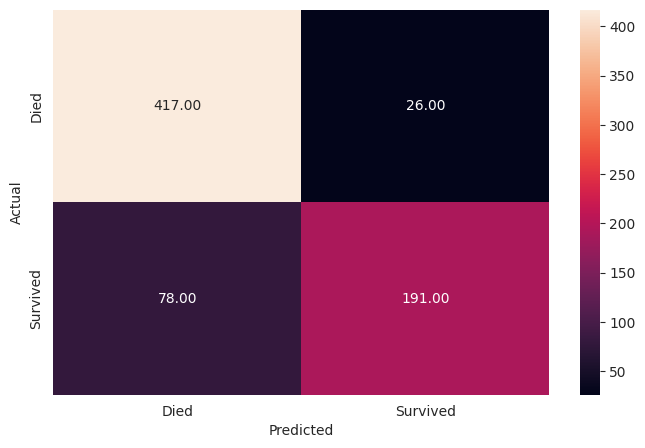

In [116]:
metrics_score(y_train,y_train_pred)

### **Model Performance on Validation Data**

In [117]:
#Making prediction using the model on the validation data to peformance metric.
y_pred=model_1.predict(x_test_scaled)

#Set the threshold of classification to be 0.5
y_pred = (y_pred > 0.5)

6/6 [==============================] - 0s 3ms/step


              precision    recall  f1-score   support

           0       0.78      0.93      0.85       106
           1       0.87      0.62      0.72        73

    accuracy                           0.80       179
   macro avg       0.82      0.78      0.78       179
weighted avg       0.81      0.80      0.80       179



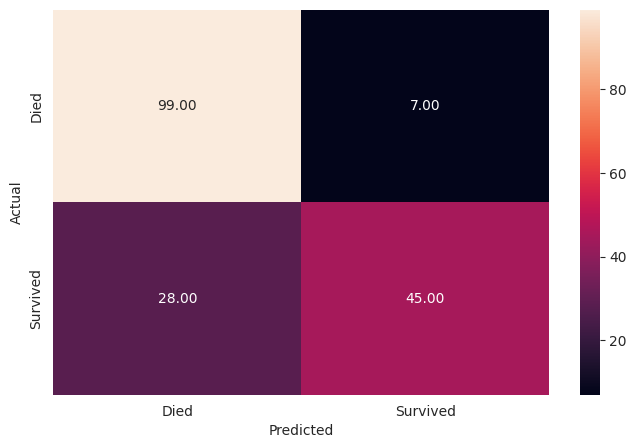

In [118]:
metrics_score(y_test,y_pred)

Observation:
- The model is performing way better on the training data than the validation data, which is a clear sign of overfitting.
- The recall of the model is significantly poorer at 64% for people who survives. This means that out of all the people that survives, only 64% of them will be correctly predicted.

Before concluding for this first model, we can do one more thing to increase the accuracy. The **ROC-AUC tuning method** to change the threshold used to classify a prediction.

### ROC-AUC Tuning

6/6 [==============================] - 0s 3ms/step
Best Threshold=0.307432, G-Mean=0.789


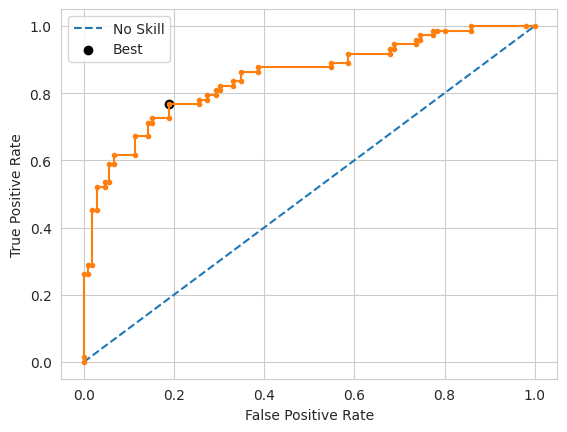

In [119]:
# predict probabilities
yhat1 = model_1.predict(x_test_scaled)

# keep probabilities for the positive outcome only
yhat1 = yhat1[:, 0]

# calculate roc curves
fpr, tpr, thresholds1 = roc_curve(y_test, yhat1)

# calculate the g-mean for each threshold
gmeans1 = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans1)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds1[ix], gmeans1[ix]))

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

# show the plot
pyplot.show()

In [120]:
#Making the prediction using the test data
y_pred_e1=model_1.predict(x_test_scaled)

#Using the threshold value to convert the predicted data into true or false statements. If the predicted data is higher than threshold, it will be labelled true.
y_pred_e1 = (y_pred_e1 > thresholds1[ix])

6/6 [==============================] - 0s 3ms/step


              precision    recall  f1-score   support

           0       0.83      0.81      0.82       106
           1       0.73      0.75      0.74        73

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



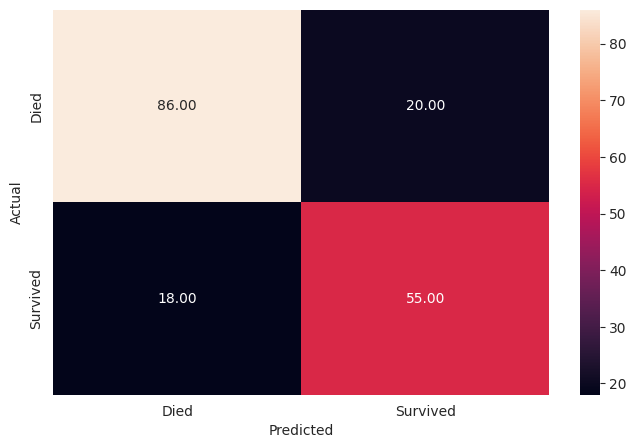

In [121]:
metrics_score(y_test, y_pred_e1)

### Observations

- We can see that overall, the performance of the model dropped a little with 1% drop in accuracy.
- The model is performing better for predicting the people who have survived, but performs poorer for predicting people who have died.
- As there were some overfitting in the model, we can do a number of things to further tune the model:
  - Change Activation function to address dying ReLu Problem
  - Lowering the learnign rate to reduce oscillation in accuracy during model tuning, and address dying relu problem

## Model 2: Adam Optimizer, Leaky ReLU, and lower learning rate

### Build Model

In [122]:
# Fixing the seed for random number generators
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Initialize sequential model
model_2 = tf.keras.Sequential([tf.keras.layers.Flatten(input_shape=(14,)),#Input layer, 14 parameters
                               tf.keras.layers.Dense(64, activation='leaky_relu'), #Hidden layer
                               tf.keras.layers.Dense(1, activation='sigmoid')]) #Output layer, only 1 node because we only have 1 result to predict

#Defining the optimizer and learnign rate
optimizer = Adam(learning_rate = 0.001)

#Using the settings for the sequential model above, create the model with the following algorithms
model_2.compile(loss = 'binary_crossentropy',
                optimizer = optimizer,
                metrics=['accuracy'])

#Show the model summary
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 14)                0         
                                                                 
 dense (Dense)               (None, 64)                960       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
_________________________________________________________________


In [123]:
# Let us now fit the model onto our data
history2 = model_2.fit(x_train_scaled,
                          y_train,
                          validation_split=0.2, #20% for validation data
                          verbose=1, #It writes the verbiage for the training progress. A higher number would give more information
                          epochs=50, #Number of times the model goes through the entire training dataset
                          batch_size=32) #This is the batch Stochastic Gradient Descend method, with batchsize per training step


Epoch 1/50
18/18 [==============================] - 1s 17ms/step - loss: 0.6428 - accuracy: 0.6450 - val_loss: 0.6298 - val_accuracy: 0.6573
Epoch 2/50
18/18 [==============================] - 0s 4ms/step - loss: 0.5597 - accuracy: 0.7399 - val_loss: 0.5584 - val_accuracy: 0.6573
Epoch 3/50
18/18 [==============================] - 0s 5ms/step - loss: 0.5105 - accuracy: 0.7768 - val_loss: 0.5122 - val_accuracy: 0.7552
Epoch 4/50
18/18 [==============================] - 0s 4ms/step - loss: 0.4784 - accuracy: 0.8207 - val_loss: 0.4823 - val_accuracy: 0.7902
Epoch 5/50
18/18 [==============================] - 0s 5ms/step - loss: 0.4574 - accuracy: 0.8278 - val_loss: 0.4629 - val_accuracy: 0.7972
Epoch 6/50
18/18 [==============================] - 0s 5ms/step - loss: 0.4417 - accuracy: 0.8366 - val_loss: 0.4505 - val_accuracy: 0.8042
Epoch 7/50
18/18 [==============================] - 0s 4ms/step - loss: 0.4298 - accuracy: 0.8366 - val_loss: 0.4424 - val_accuracy: 0.8042
Epoch 8/50
18/18 [=

### Model Accuracy and Loss with Epochs

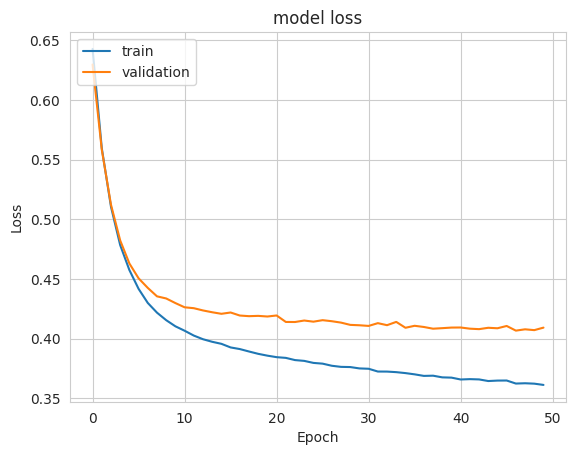

In [124]:
#Plotting Train Loss vs Validation Loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

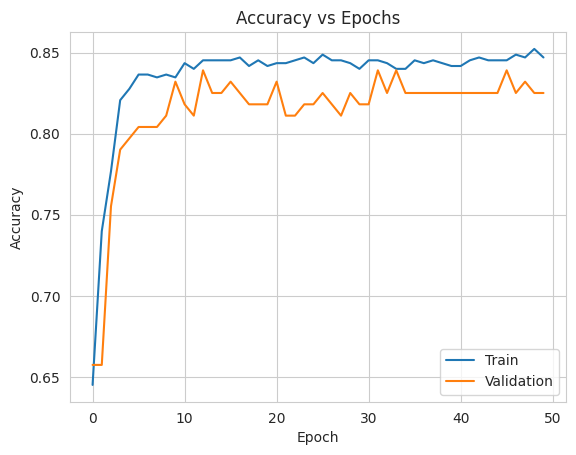

In [125]:
#Plotting Epoch vs accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Accuracy vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

### Model Performance on training data

23/23 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       443
           1       0.87      0.70      0.77       269

    accuracy                           0.85       712
   macro avg       0.85      0.82      0.83       712
weighted avg       0.85      0.85      0.84       712



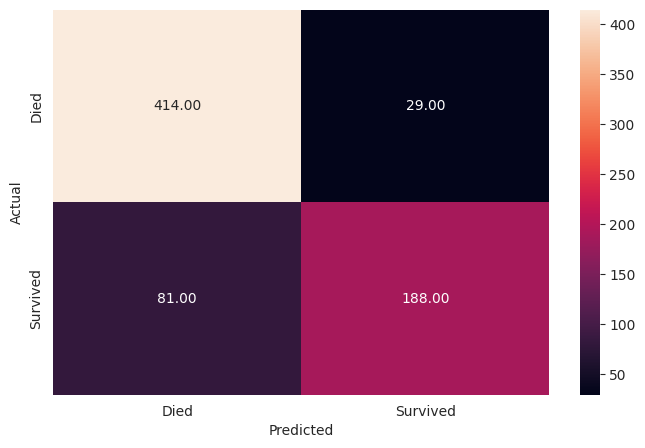

In [ ]:
# Using the model to make predictions on the training data
y_train_pred = model_2.predict(x_train_scaled)

#Set the threshold of classification to be 0.5
y_train_pred = (y_train_pred > 0.5)

#Performance of model on training data
metrics_score(y_train,y_train_pred)

### Model Performance with validation data

6/6 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.78      0.93      0.85       106
           1       0.87      0.62      0.72        73

    accuracy                           0.80       179
   macro avg       0.82      0.78      0.78       179
weighted avg       0.81      0.80      0.80       179



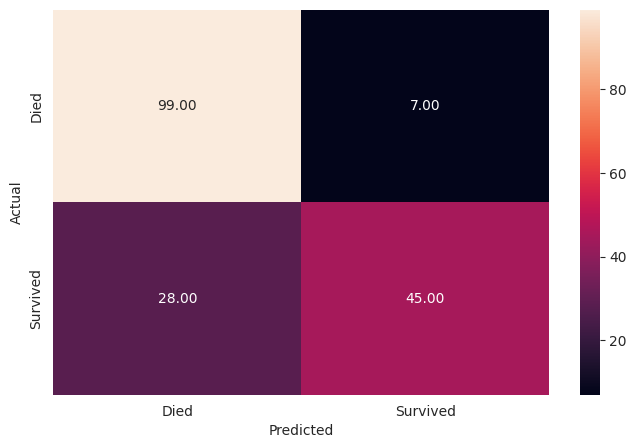

In [ ]:
#Making prediction using the model on the validation data to peformance metric.
y_pred=model_2.predict(x_test_scaled)

#Set the threshold of classification to be 0.5
y_pred = (y_pred > 0.5)

#Performance on validation data
metrics_score(y_test,y_pred)

### ROC-AUC Tuning

6/6 [==============================] - 0s 3ms/step
Best Threshold=0.392621, G-Mean=0.785


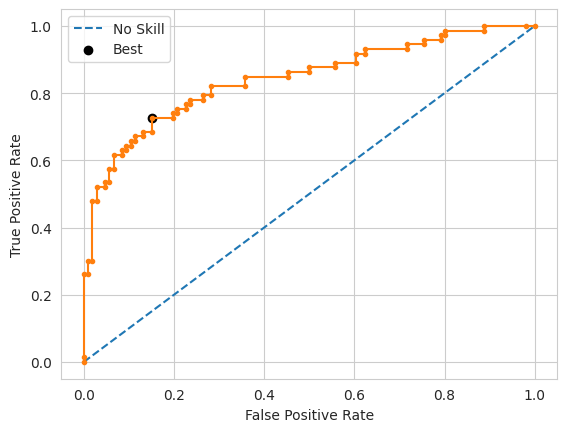

In [ ]:
# predict probabilities
yhat2 = model_2.predict(x_test_scaled)

# keep probabilities for the positive outcome only
yhat2 = yhat2[:, 0]

# calculate roc curves
fpr, tpr, thresholds2 = roc_curve(y_test, yhat2)

# calculate the g-mean for each threshold
gmeans2 = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans2)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds2[ix], gmeans2[ix]))

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

# show the plot
pyplot.show()

6/6 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       106
           1       0.76      0.71      0.74        73

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



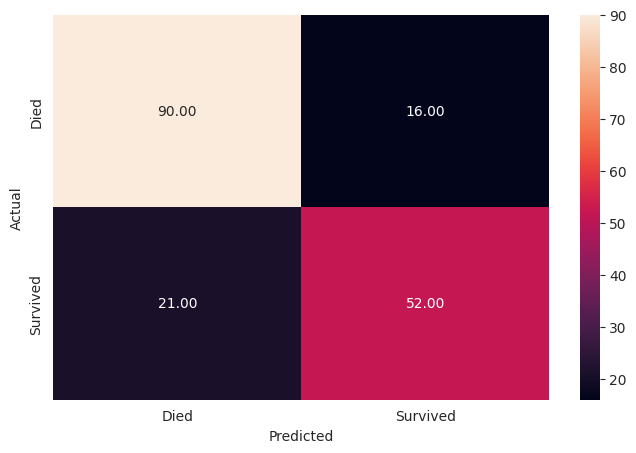

In [ ]:
#Making the prediction using the test data
y_pred_e2=model_2.predict(x_test_scaled)

#Using the threshold value to convert the predicted data into true or false statements. If the predicted data is higher than threshold, it will be labelled true.
y_pred_e2 = (y_pred_e2 > thresholds2[ix])

metrics_score(y_test, y_pred_e2)

### Observations

- Performance of model remains the same as overall accuracy remaining the same.
- Accuracy vs epoch curve is more responsive and no more dying relu issue
- But it is a little bit too janky, so maybe need to lower learning rate further
- Amount of loss for validation data remains high with more epoch, but the loss decreases with more epoch. THis means signs of overfitting.

Recommendations:

- Continue with leaky relu
- Decrease learning rate further, 0.0005
- Try using Adamax since it simpolifies the algorithm to deal with overfitting
- May need to include dropout to see if it helps with the overfitting
- Increase the number of layers as the performance on training data is not very high

## Model 3: Adamax, Leaky ReLU, lower learning rate, one more layer, 0.2 dropout

### Build Model

In [ ]:
# Fixing the seed for random number generators
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

from keras.optimizers import Adamax

# Initialize sequential model
model_3 = tf.keras.Sequential([tf.keras.layers.Flatten(input_shape=(14,)),#Input layer, 14 parameters
                               tf.keras.layers.Dense(64, activation='leaky_relu'), #Hidden layer
                               tf.keras.layers.Dropout(0.2), #Dropout 20%
                               tf.keras.layers.Dense(64, activation='leaky_relu'), #2nd Hidden layer
                               tf.keras.layers.Dropout(0.2), #Dropout 20%
                               tf.keras.layers.Dense(1, activation='sigmoid')]) #Output layer, only 1 node because we only have 1 result to predict

#Defining the optimizer and learnign rate
optimizer = Adamax(learning_rate = 0.0005)

#Using the settings for the sequential model above, create the model with the following algorithms
model_3.compile(loss = 'binary_crossentropy',
                optimizer = optimizer,
                metrics=['accuracy'])

#Show the model summary
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 14)                0         
                                                                 
 dense (Dense)               (None, 64)                960       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,185
Trainable params: 5,185
Non-trainabl

In [ ]:
# Let us now fit the model onto our data
history3 = model_3.fit(x_train_scaled,
                          y_train,
                          validation_split=0.2, #20% for validation data
                          verbose=1, #It writes the verbiage for the training progress. A higher number would give more information
                          epochs=100, #Number of times the model goes through the entire training dataset
                          batch_size=32) #This is the batch Stochastic Gradient Descend method, with batchsize per training step

Epoch 1/100
18/18 [==============================] - 1s 17ms/step - loss: 0.6451 - accuracy: 0.6608 - val_loss: 0.6115 - val_accuracy: 0.7413
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: 0.6097 - accuracy: 0.7135 - val_loss: 0.5841 - val_accuracy: 0.7273
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 0.5908 - accuracy: 0.7118 - val_loss: 0.5610 - val_accuracy: 0.7203
Epoch 4/100
18/18 [==============================] - 0s 5ms/step - loss: 0.5666 - accuracy: 0.7293 - val_loss: 0.5421 - val_accuracy: 0.7203
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 0.5526 - accuracy: 0.7399 - val_loss: 0.5254 - val_accuracy: 0.7343
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - loss: 0.5374 - accuracy: 0.7803 - val_loss: 0.5119 - val_accuracy: 0.7622
Epoch 7/100
18/18 [==============================] - 0s 5ms/step - loss: 0.5206 - accuracy: 0.7733 - val_loss: 0.4997 - val_accuracy: 0.7622
Epoch 8/100


### Model Accuracy and Loss with Epochs

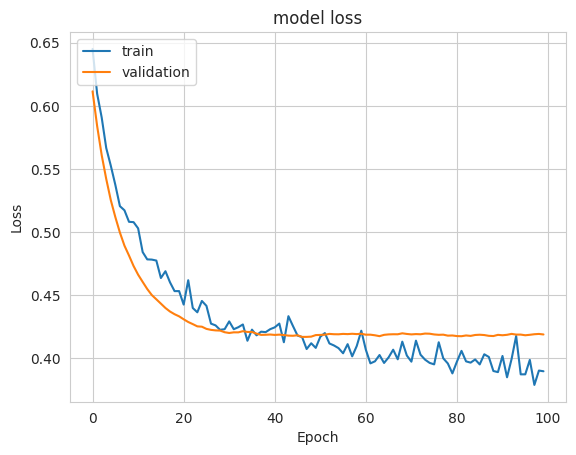

In [ ]:
#Plotting Train Loss vs Validation Loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

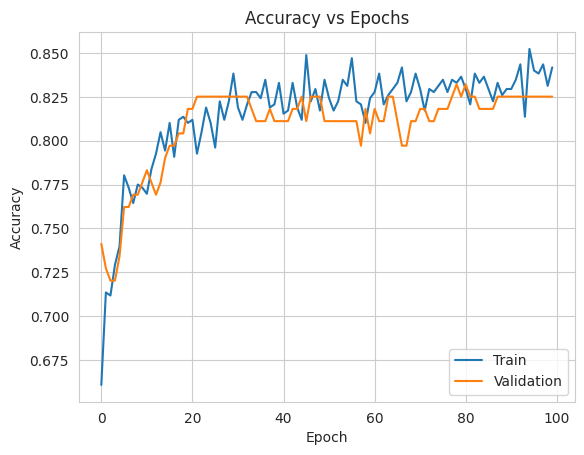

In [ ]:
#Plotting Epoch vs accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Accuracy vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

### Model Performance on training data

23/23 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.83      0.93      0.87       443
           1       0.85      0.68      0.76       269

    accuracy                           0.83       712
   macro avg       0.84      0.80      0.82       712
weighted avg       0.84      0.83      0.83       712



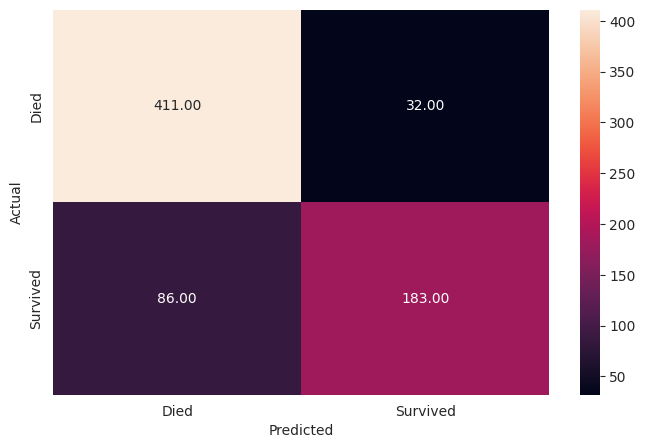

In [ ]:
# Using the model to make predictions on the training data
y_train_pred = model_3.predict(x_train_scaled)

#Set the threshold of classification to be 0.5
y_train_pred = (y_train_pred > 0.5)

#Performance of model on training data
metrics_score(y_train,y_train_pred)

### Model Performance with validation data

6/6 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.78      0.92      0.85       106
           1       0.85      0.63      0.72        73

    accuracy                           0.80       179
   macro avg       0.82      0.78      0.79       179
weighted avg       0.81      0.80      0.80       179



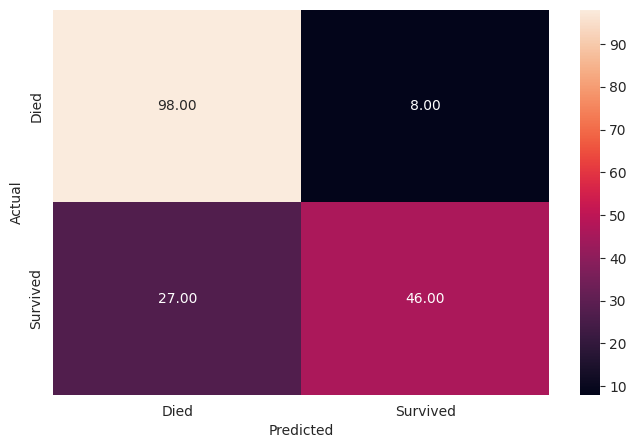

In [ ]:
#Making prediction using the model on the validation data to peformance metric.
y_pred=model_3.predict(x_test_scaled)

#Set the threshold of classification to be 0.5
y_pred = (y_pred > 0.5)

#Performance on validation data
metrics_score(y_test,y_pred)

### ROC-AUC Tuning

6/6 [==============================] - 0s 2ms/step
Best Threshold=0.295844, G-Mean=0.798


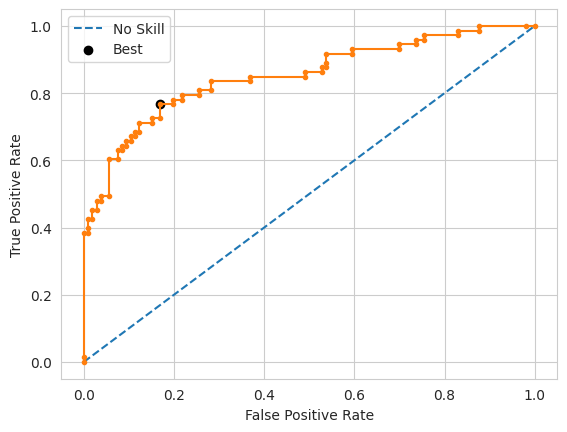

In [ ]:
# predict probabilities
yhat3 = model_3.predict(x_test_scaled)

# keep probabilities for the positive outcome only
yhat3 = yhat3[:, 0]

# calculate roc curves
fpr, tpr, thresholds3 = roc_curve(y_test, yhat3)

# calculate the g-mean for each threshold
gmeans3 = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans3)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds3[ix], gmeans3[ix]))

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

# show the plot
pyplot.show()

6/6 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       106
           1       0.75      0.75      0.75        73

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



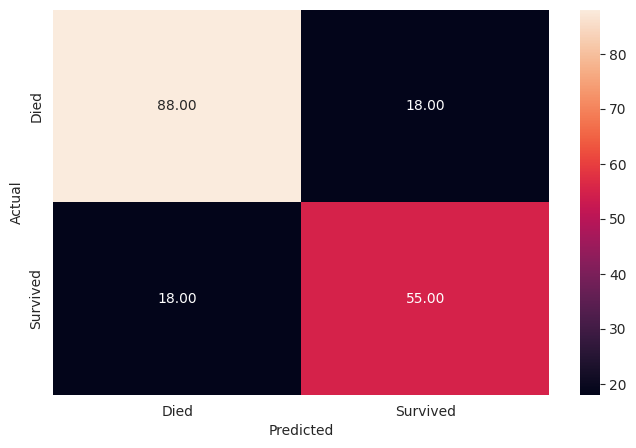

In [ ]:
#Making the prediction using the test data
y_pred_e3=model_3.predict(x_test_scaled)

#Using the threshold value to convert the predicted data into true or false statements. If the predicted data is higher than threshold, it will be labelled true.
y_pred_e3 = (y_pred_e3 > thresholds3[ix])

metrics_score(y_test, y_pred_e3)

### Observations

- Loss vs epoch took longer to learn, and training curve became less smooth. This could be due to the dropout regularizations, affecting the learning process.
- Accuracy vs epoch curves are also very oscillatory for both, and this could mean that the learning rate is still too high, or the optimizer is not so suitable
- The model's performance on training data has dropped, but the performance on validation data maintains. This is a good sign of lesser overfitting, but can still be further improved with more regularization techniques or smaller batch size

Recommendations:

- Epoch can stop earlier, around 40 - 50 to prevent overfitting
- Batch Normalization to deal with the overfitting

## Model 4: Adamax, Leaky ReLU, batch normalization

### Build Model

In [ ]:
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras import regularizers

# Fixing the seed for random number generators
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Initialize sequential model
model_4 = tf.keras.Sequential([tf.keras.layers.Flatten(input_shape=(14,)),#Input layer, 14 parameters
                               tf.keras.layers.Dense(64, activation='leaky_relu'), #Hidden layer
                               tf.keras.layers.Dropout(0.2), #Dropout 20%
                               BatchNormalization(),
                               tf.keras.layers.Dense(64, activation='leaky_relu'), # 2nd Hidden layer
                               tf.keras.layers.Dropout(0.2), #Dropout 20%
                               BatchNormalization(),
                               tf.keras.layers.Dense(1, activation='sigmoid')]) #Output layer, only 1 node because we only have 1 result to predict

#Defining the optimizer and learnign rate
optimizer = Adamax(learning_rate = 0.0005)

#Using the settings for the sequential model above, create the model with the following algorithms
model_4.compile(loss = 'binary_crossentropy',
                optimizer = optimizer,
                metrics=['accuracy'])

#Show the model summary
model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 14)                0         
                                                                 
 dense (Dense)               (None, 64)                960       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [ ]:
# Let us now fit the model onto our data
history4 = model_4.fit(x_train_scaled,
                          y_train,
                          validation_split=0.2, #20% for validation data
                          verbose=1, #It writes the verbiage for the training progress. A higher number would give more information
                          epochs=50, #Number of times the model goes through the entire training dataset
                          batch_size=64) #This is the batch Stochastic Gradient Descend method, with batchsize per training step

Epoch 1/50
9/9 [==============================] - 1s 41ms/step - loss: 0.7539 - accuracy: 0.6081 - val_loss: 0.6326 - val_accuracy: 0.7203
Epoch 2/50
9/9 [==============================] - 0s 10ms/step - loss: 0.6731 - accuracy: 0.6555 - val_loss: 0.6142 - val_accuracy: 0.7343
Epoch 3/50
9/9 [==============================] - 0s 9ms/step - loss: 0.6617 - accuracy: 0.6643 - val_loss: 0.5974 - val_accuracy: 0.7273
Epoch 4/50
9/9 [==============================] - 0s 8ms/step - loss: 0.6141 - accuracy: 0.6819 - val_loss: 0.5829 - val_accuracy: 0.7273
Epoch 5/50
9/9 [==============================] - 0s 10ms/step - loss: 0.5750 - accuracy: 0.7135 - val_loss: 0.5704 - val_accuracy: 0.7203
Epoch 6/50
9/9 [==============================] - 0s 7ms/step - loss: 0.5549 - accuracy: 0.7329 - val_loss: 0.5587 - val_accuracy: 0.7343
Epoch 7/50
9/9 [==============================] - 0s 7ms/step - loss: 0.5458 - accuracy: 0.7417 - val_loss: 0.5479 - val_accuracy: 0.7483
Epoch 8/50
9/9 [===============

### Model Accuracy and Loss with Epochs

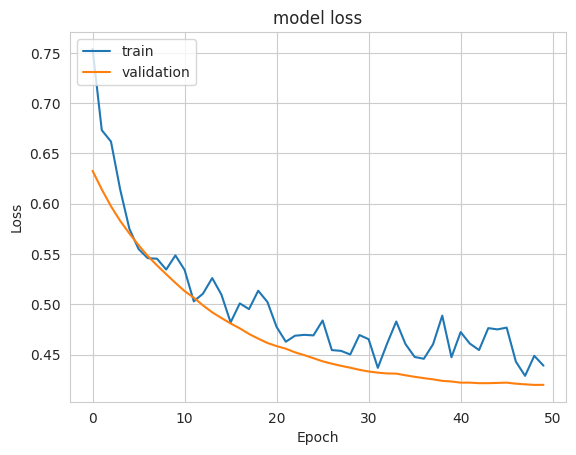

In [ ]:
#Plotting Train Loss vs Validation Loss
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

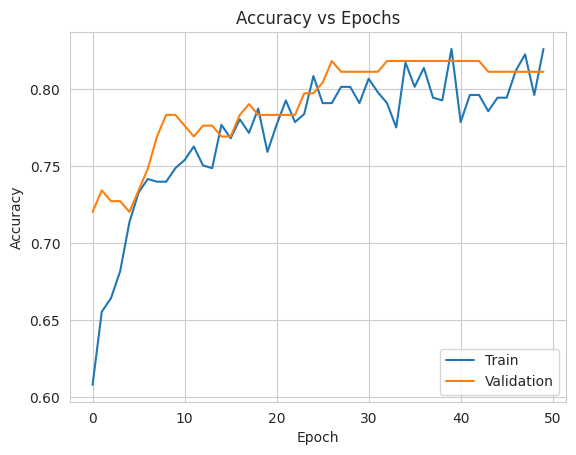

In [ ]:
#Plotting Epoch vs accuracy
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Accuracy vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

### Model Performance on training data

23/23 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       443
           1       0.86      0.67      0.75       269

    accuracy                           0.83       712
   macro avg       0.84      0.80      0.81       712
weighted avg       0.84      0.83      0.83       712



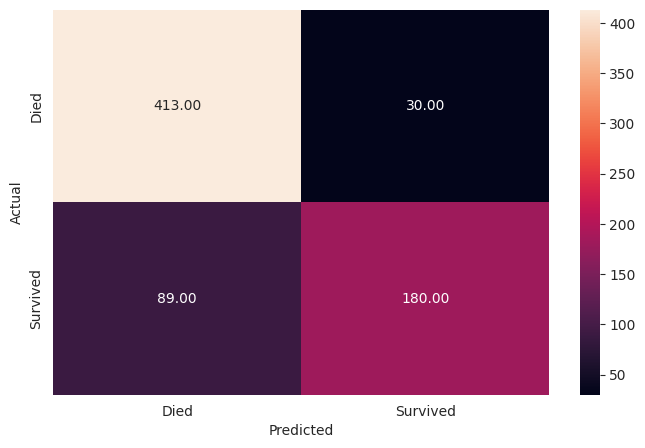

In [ ]:
# Using the model to make predictions on the training data
y_train_pred = model_4.predict(x_train_scaled)

#Set the threshold of classification to be 0.5
y_train_pred = (y_train_pred > 0.5)

#Performance of model on training data
metrics_score(y_train,y_train_pred)

### Model Performance with validation data

6/6 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.78      0.92      0.85       106
           1       0.85      0.63      0.72        73

    accuracy                           0.80       179
   macro avg       0.82      0.78      0.79       179
weighted avg       0.81      0.80      0.80       179



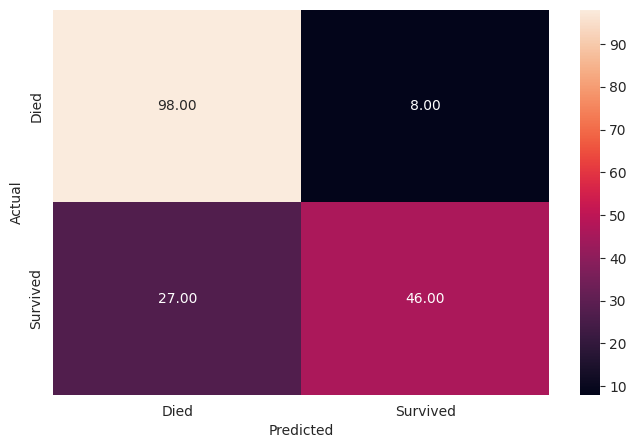

In [ ]:
#Making prediction using the model on the validation data to peformance metric.
y_pred=model_4.predict(x_test_scaled)

#Set the threshold of classification to be 0.5
y_pred = (y_pred > 0.5)

#Performance on validation data
metrics_score(y_test,y_pred)

### ROC-AUC Tuning

6/6 [==============================] - 0s 2ms/step
Best Threshold=0.433699, G-Mean=0.795


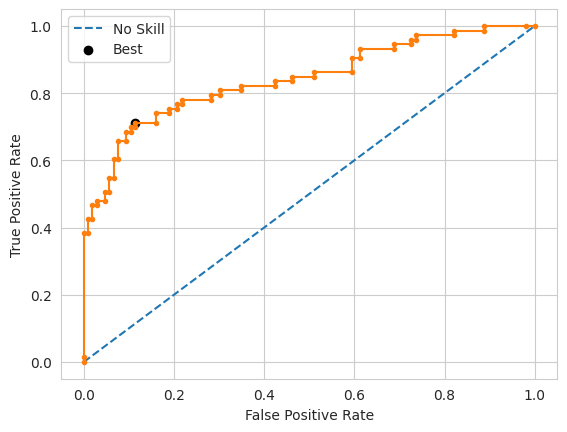

In [ ]:
# predict probabilities
yhat4 = model_4.predict(x_test_scaled)

# keep probabilities for the positive outcome only
yhat4 = yhat4[:, 0]

# calculate roc curves
fpr, tpr, thresholds4 = roc_curve(y_test, yhat4)

# calculate the g-mean for each threshold
gmeans4 = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans4)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds4[ix], gmeans4[ix]))

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

# show the plot
pyplot.show()

6/6 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       106
           1       0.81      0.70      0.75        73

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179



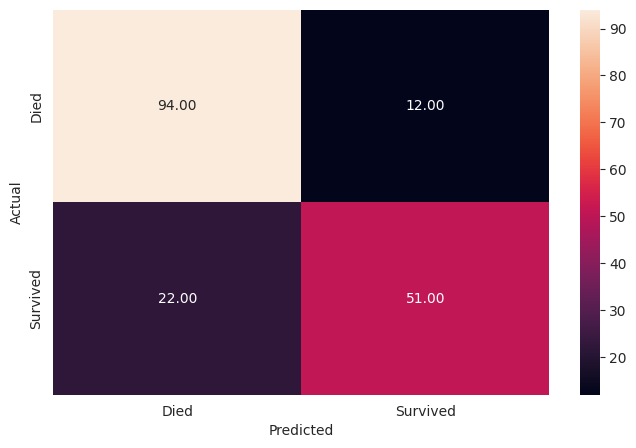

In [ ]:
#Making the prediction using the test data
y_pred_e4=model_4.predict(x_test_scaled)

#Using the threshold value to convert the predicted data into true or false statements. If the predicted data is higher than threshold, it will be labelled true.
y_pred_e4 = (y_pred_e4 > thresholds4[ix])

metrics_score(y_test, y_pred_e4)

### Observations

- Accuracy of model improved from 80% to 81%
- Lesser overfitting as a result of the batch normalization, larger batch size, and lesser epochs
- The accuracy of the model seems to drop with epochs above 40, so epoch needs to be tuned as well

Recommendations:

- Time to use some sort of automated tuning for this parameters.

## Keras Tuner - Finding number of layers and neurons

In [ ]:
def build_model(h):

  # Clear previous session
  backend.clear_session()
  np.random.seed(42)
  random.seed(42)
  tf.random.set_seed(42)

  # Initialize sequential model
  model = keras.Sequential()

  # Add hidden layers (input layer will be adjusted automatically based on shape of input data)
  for i in range(h.Int('num_layers', 2, 10)):
    model.add(layers.Dense(units=h.Int('units_' + str(i),
                                        min_value=32,
                                        max_value=128,
                                        step=32),
                                        activation='leaky_relu'))

  # Add the output layer
  model.add(layers.Dense(1, activation='sigmoid'))

  # Using the settings for the sequential model above, create the model with the following algorithms
  model.compile(optimizer=keras.optimizers.Adamax(
                h.Choice('learning_rate', [0.0003, 0.0005, 0.0007])), #Choice() returns a random option from list
                loss='binary_crossentropy',
                metrics=['accuracy'])

  return model

In [ ]:
# Install Keras Tuner
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

# Initialie the tuner using randomsearch
tuner = RandomSearch(build_model,
                     objective='val_accuracy',
                     max_trials=5,
                     executions_per_trial=3, #Number of different models to try
                     project_name='Job_')

# See what combination of values were simulated
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.0003, 'conditions': [], 'values': [0.0003, 0.0005, 0.0007], 'ordered': True}


In [ ]:
# Searching the best model on training data
tuner.search(x_train_scaled, y_train,
             epochs=50,
             validation_split = 0.2)

Trial 5 Complete [00h 00m 30s]
val_accuracy: 0.8251748085021973

Best val_accuracy So Far: 0.8531468510627747
Total elapsed time: 00h 04m 27s


In [ ]:
# Printing the best models with their hyperparameters
tuner.results_summary()

Results summary
Results in ./Job_
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
num_layers: 9
units_0: 96
units_1: 96
learning_rate: 0.0003
units_2: 128
units_3: 96
units_4: 96
units_5: 96
units_6: 64
units_7: 64
units_8: 32
Score: 0.8531468510627747

Trial 3 summary
Hyperparameters:
num_layers: 9
units_0: 128
units_1: 96
learning_rate: 0.0003
units_2: 64
units_3: 64
units_4: 64
units_5: 64
units_6: 96
units_7: 64
units_8: 32
Score: 0.8531468510627747

Trial 0 summary
Hyperparameters:
num_layers: 8
units_0: 128
units_1: 64
learning_rate: 0.0005
units_2: 32
units_3: 32
units_4: 32
units_5: 32
units_6: 32
units_7: 32
Score: 0.8461538553237915

Trial 1 summary
Hyperparameters:
num_layers: 6
units_0: 64
units_1: 64
learning_rate: 0.0003
units_2: 32
units_3: 64
units_4: 96
units_5: 32
units_6: 128
units_7: 32
Score: 0.8321678042411804

Trial 4 summary
Hyperparameters:
num_layers: 2
units_0: 32
units_1: 32
learning_rate: 0.0005
units

### Build Model

In [126]:
## Create model based on tuner results

# Clear session
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Initialize sequential model
modelkeras = tf.keras.Sequential([tf.keras.layers.Flatten(input_shape=(14,)),#Input layer, 14 parameters
                                  tf.keras.layers.Dense(128, activation='leaky_relu'), # 0 Hidden layer
                                  tf.keras.layers.Dense(96, activation='leaky_relu'), # 1 Hidden layer
                                  tf.keras.layers.Dense(64, activation='leaky_relu'), # 2 Hidden layer
                                  tf.keras.layers.Dense(64, activation='leaky_relu'), # 3 Hidden layer
                                  tf.keras.layers.Dense(64, activation='leaky_relu'), # 4 Hidden layer
                                  tf.keras.layers.Dense(64, activation='leaky_relu'), # 5 Hidden layer
                                  tf.keras.layers.Dense(96, activation='leaky_relu'), # 6 Hidden layer
                                  tf.keras.layers.Dense(64, activation='leaky_relu'), # 7 Hidden layer
                                  tf.keras.layers.Dense(32, activation='leaky_relu'), # 8 Hidden layer
                                  tf.keras.layers.Dense(1, activation='sigmoid')]) #Output layer, only 1 node because we only have 1 result to predict

# Compile model using oparameters
optimizer = tf.keras.optimizers.Adamax(0.0003)
modelkeras.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

# See summary
modelkeras.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 14)                0         
                                                                 
 dense (Dense)               (None, 128)               1920      
                                                                 
 dense_1 (Dense)             (None, 96)                12384     
                                                                 
 dense_2 (Dense)             (None, 64)                6208      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 64)                4

In [127]:
history_keras = modelkeras.fit(x_train_scaled,
                       y_train,
                       batch_size=64,
                       epochs=150,
                       verbose=1,
                       validation_split = 0.2)

Epoch 1/150
9/9 [==============================] - 5s 118ms/step - loss: 0.6835 - accuracy: 0.6134 - val_loss: 0.6685 - val_accuracy: 0.6573
Epoch 2/150
9/9 [==============================] - 0s 25ms/step - loss: 0.6659 - accuracy: 0.6134 - val_loss: 0.6463 - val_accuracy: 0.6573
Epoch 3/150
9/9 [==============================] - 0s 27ms/step - loss: 0.6434 - accuracy: 0.6134 - val_loss: 0.6185 - val_accuracy: 0.6573
Epoch 4/150
9/9 [==============================] - 0s 37ms/step - loss: 0.6185 - accuracy: 0.6134 - val_loss: 0.5902 - val_accuracy: 0.6643
Epoch 5/150
9/9 [==============================] - 0s 25ms/step - loss: 0.5926 - accuracy: 0.6661 - val_loss: 0.5604 - val_accuracy: 0.7273
Epoch 6/150
9/9 [==============================] - 0s 28ms/step - loss: 0.5671 - accuracy: 0.7311 - val_loss: 0.5366 - val_accuracy: 0.7552
Epoch 7/150
9/9 [==============================] - 0s 18ms/step - loss: 0.5490 - accuracy: 0.7575 - val_loss: 0.5173 - val_accuracy: 0.7902
Epoch 8/150
9/9 [==

### Model Accuracy and Loss with Epochs

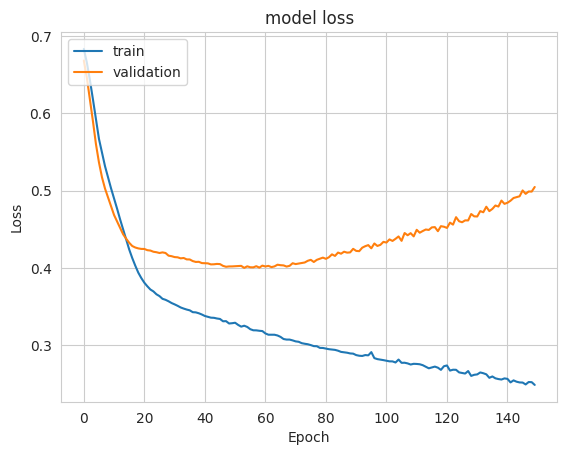

In [128]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_keras.history['loss'])
plt.plot(history_keras.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

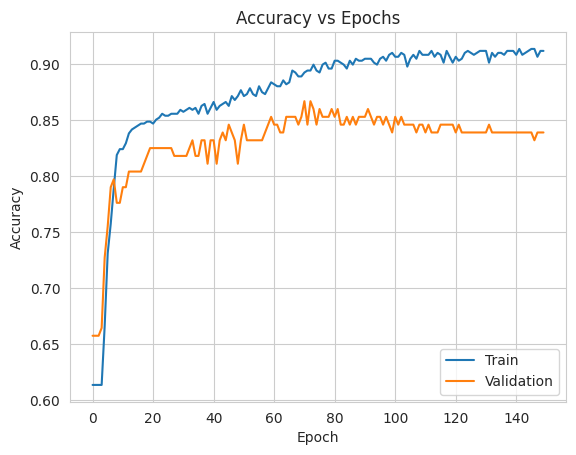

In [129]:
#Plotting Epoch vs accuracy
plt.plot(history_keras.history['accuracy'])
plt.plot(history_keras.history['val_accuracy'])
plt.title('Accuracy vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

### Model Performance on training data

23/23 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       443
           1       0.91      0.81      0.86       269

    accuracy                           0.90       712
   macro avg       0.90      0.88      0.89       712
weighted avg       0.90      0.90      0.90       712



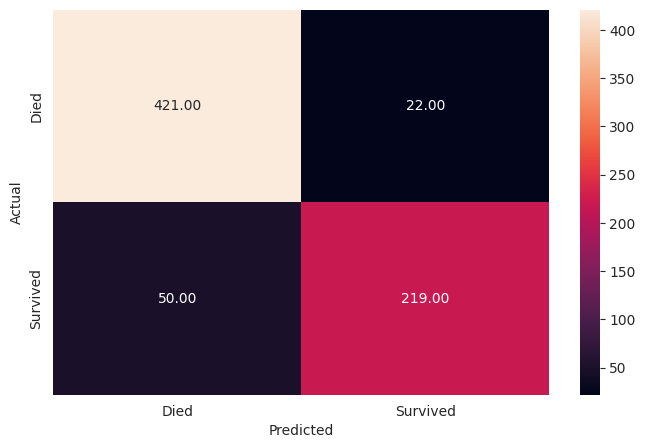

In [130]:
# Using the model to make predictions on the training data
y_train_pred = modelkeras.predict(x_train_scaled)

#Set the threshold of classification to be 0.5
y_train_pred = (y_train_pred > 0.5)

#Performance of model on training data
metrics_score(y_train,y_train_pred)

### Model Performance with validation data

6/6 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       106
           1       0.73      0.62      0.67        73

    accuracy                           0.75       179
   macro avg       0.74      0.73      0.73       179
weighted avg       0.75      0.75      0.74       179



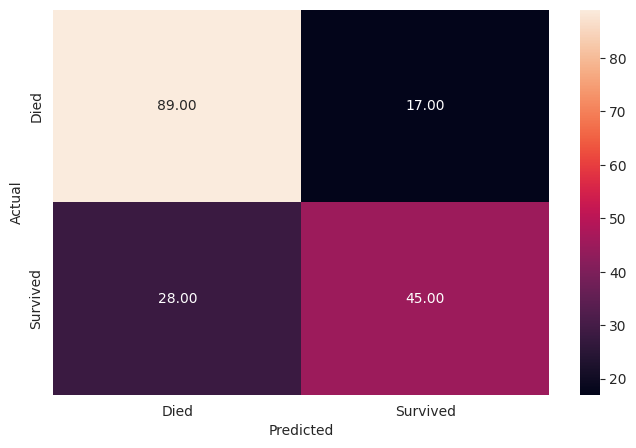

In [131]:
#Making prediction using the model on the validation data to peformance metric.
y_pred=modelkeras.predict(x_test_scaled)

#Set the threshold of classification to be 0.5
y_pred = (y_pred > 0.5)

#Performance on validation data
metrics_score(y_test,y_pred)

### ROC-AUC Tuning

6/6 [==============================] - 0s 2ms/step
Best Threshold=0.150022, G-Mean=0.769


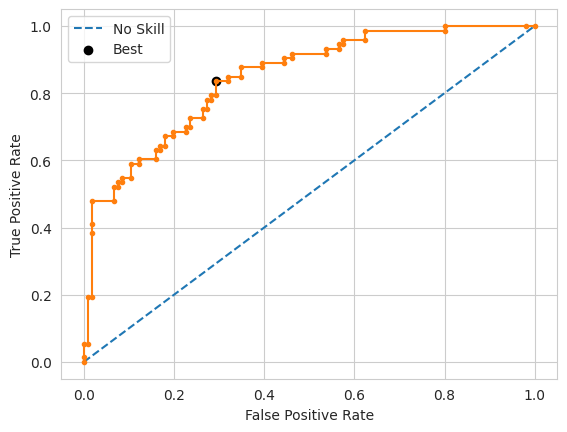

In [132]:
# predict probabilities
yhatkeras = modelkeras.predict(x_test_scaled)

# keep probabilities for the positive outcome only
yhatkeras = yhatkeras[:, 0]

# calculate roc curves
fpr, tpr, thresholdskeras = roc_curve(y_test, yhatkeras)

# calculate the g-mean for each threshold
gmeanskeras = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeanskeras)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholdskeras[ix], gmeanskeras[ix]))

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

# show the plot
pyplot.show()

6/6 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.85      0.71      0.77       106
           1       0.66      0.82      0.73        73

    accuracy                           0.75       179
   macro avg       0.76      0.76      0.75       179
weighted avg       0.77      0.75      0.76       179



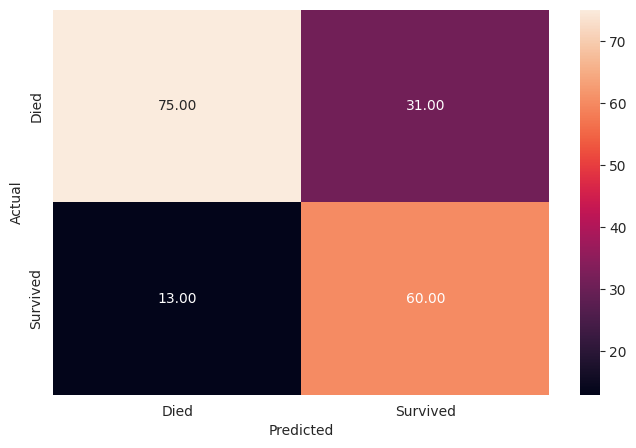

In [133]:
#Making the prediction using the test data
y_pred_e4=modelkeras.predict(x_test_scaled)

#Using the threshold value to convert the predicted data into true or false statements. If the predicted data is higher than threshold, it will be labelled true.
y_pred_e4 = (y_pred_e4 > thresholdskeras[ix])

metrics_score(y_test, y_pred_e4)

### Observations

- Performance on trianing data raised from 85% to 89%.
- But the performance on validation data dropped to 75%.This big difference is a sign of overfitting
- AUC-ROC tuning then improves the accuracy to 77%, which is still lower than model 4.
- The accuracy of the model increases with 77 epochs, but began to drop after 80.
- Overfitting is very obvious beyond 80 epochs, as the accuracy of validation dataset continues to drop with more epoch.

Recommendations:

- So we will still try to optimize model 4 instead of the one created by keras tuner.

## Model 5: Dask Tuner on Model 4

### Import Dask libraries

In [ ]:
# Try below code to install dask in Google Colab
!pip install dask-ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.8/149.8 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00


In [ ]:
# importing library
from dask_ml.model_selection import GridSearchCV as DaskGridSearchCV

### Dask Tuning of Parameters

In [ ]:
def create_model(lr,batch_size,dropout1,dropout2):

    # Fixing the seed for random number generators
    np.random.seed(42)

    # Initialize sequential model
    model = Sequential()
    model.add(Dense(64, activation='leaky_relu', input_dim = x_train.shape[1])) # Add the input layer and the first layer
    model.add(Dropout(dropout1))
    model.add(BatchNormalization())
    model.add(Dense(64,activation='leaky_relu'))
    model.add(Dropout(dropout2))
    model.add(BatchNormalization())
    # model.add(Dense(64,activation='leaky_relu'))
    # model.add(Dropout(dropout))
    # model.add(BatchNormalization())
    # model.add(Dense(32,activation='leaky_relu'))
    # model.add(Dropout(dropout))
    # model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    #Defining the optimizer and learnign rate
    optimizer = Adamax(learning_rate = lr)

    #Using the settings for the sequential model above, create the model with the following algorithms
    model.compile(loss = 'binary_crossentropy',
                    optimizer = optimizer,
                    metrics=['accuracy'])

    return model

In [ ]:
#Reset the session
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# define the grid search parameters
param_dask = {'batch_size':[32, 64, 128],
              "lr":[0.0003, 0.0005, 0.0007, 0.001],
              'dropout1':[0.1, 0.2, 0.3],
              'dropout2':[0.1, 0.2, 0.3]}

#Create the classifer
keras_estimator = KerasClassifier(build_fn=create_model,
                                  epochs = 150,
                                  batch_size = 0,
                                  verbose=1)

#Dask Tuner setting
kfold_splits = 3
dask = DaskGridSearchCV(estimator=keras_estimator,
                        cv=kfold_splits,
                        param_grid=param_dask,
                        n_jobs=-1)

In [ ]:
import time

# store starting time
begin = time.time()

#Fit the optimizer
dask_result = dask.fit(x_train_scaled, y_train,validation_split=0.2,verbose=1)

# Summarize results
print("Best: %f using %s" % (dask_result.best_score_, dask_result.best_params_))

# store end time (Took almost 3 hours to run during tests)
time.sleep(1)
end = time.time()

# total time taken
print(f"Total runtime of the program is {end - begin}")

Streaming output truncated to the last 5000 lines.
Epoch 133/150
3/3 [==============================] - 0s 76ms/step - loss: 0.4080 - accuracy: 0.8132 - val_loss: 0.3746 - val_accuracy: 0.8737
Epoch 79/150
3/3 [==============================] - 0s 85ms/step - loss: 0.3995 - accuracy: 0.8526 - val_loss: 0.4688 - val_accuracy: 0.7789
Epoch 134/150
3/3 [==============================] - 0s 68ms/step - loss: 0.4405 - accuracy: 0.7921 - val_loss: 0.3742 - val_accuracy: 0.8737
Epoch 80/150
3/3 [==============================] - 0s 77ms/step - loss: 0.3744 - accuracy: 0.8500 - val_loss: 0.4693 - val_accuracy: 0.7789
Epoch 135/150
3/3 [==============================] - 0s 72ms/step - loss: 0.4017 - accuracy: 0.8132 - val_loss: 0.3737 - val_accuracy: 0.8737
Epoch 81/150
3/3 [==============================] - 0s 80ms/step - loss: 0.3978 - accuracy: 0.8526 - val_loss: 0.4697 - val_accuracy: 0.7789
Epoch 136/150
3/3 [==============================] - 0s 70ms/step - loss: 0.4068 - accuracy: 0.8184 

### Build Model with best parameters

In [ ]:
dask_model = create_model(batch_size=dask_result.best_params_['batch_size'],
                          lr=dask_result.best_params_['lr'],
                          dropout1=dask_result.best_params_['dropout1'],
                          dropout2=dask_result.best_params_['dropout2'])

optimizer = tf.keras.optimizers.Adamax(dask_result.best_params_['lr'])

dask_model.compile(loss='binary_crossentropy',
                   optimizer=optimizer,
                   metrics=['accuracy'])

dask_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1920      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                        

In [ ]:
history_dask = dask_model.fit(x_train_scaled,
                            y_train,
                            epochs=150,
                            batch_size = dask_result.best_params_['batch_size'],
                            verbose=1,
                            validation_split=0.2)

Epoch 1/150
9/9 [==============================] - 4s 146ms/step - loss: 0.7529 - accuracy: 0.6397 - val_loss: 0.7019 - val_accuracy: 0.5245
Epoch 2/150
9/9 [==============================] - 0s 38ms/step - loss: 0.5952 - accuracy: 0.7153 - val_loss: 0.6400 - val_accuracy: 0.6713
Epoch 3/150
9/9 [==============================] - 0s 35ms/step - loss: 0.5687 - accuracy: 0.7311 - val_loss: 0.5962 - val_accuracy: 0.7273
Epoch 4/150
9/9 [==============================] - 0s 31ms/step - loss: 0.5195 - accuracy: 0.7487 - val_loss: 0.5679 - val_accuracy: 0.7483
Epoch 5/150
9/9 [==============================] - 0s 23ms/step - loss: 0.5601 - accuracy: 0.7417 - val_loss: 0.5480 - val_accuracy: 0.7692
Epoch 6/150
9/9 [==============================] - 0s 42ms/step - loss: 0.4918 - accuracy: 0.7768 - val_loss: 0.5310 - val_accuracy: 0.7972
Epoch 7/150
9/9 [==============================] - 0s 34ms/step - loss: 0.5149 - accuracy: 0.7540 - val_loss: 0.5162 - val_accuracy: 0.7902
Epoch 8/150
9/9 [==

### Model Accuracy and Loss with Epochs

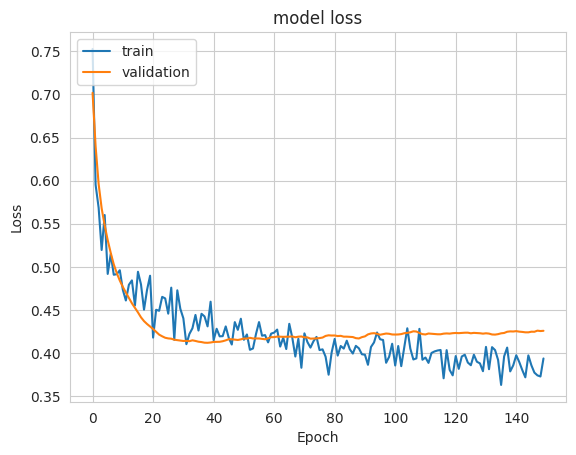

In [ ]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_dask.history['loss'])
plt.plot(history_dask.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

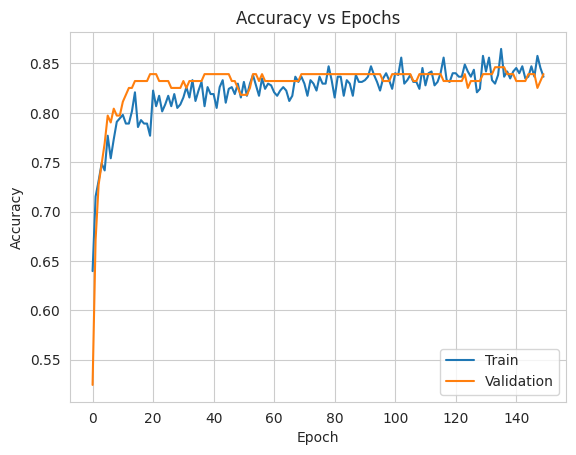

In [ ]:
#Plotting Epoch vs accuracy
plt.plot(history_dask.history['accuracy'])
plt.plot(history_dask.history['val_accuracy'])
plt.title('Accuracy vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

### Model Performance on training data

23/23 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.84      0.96      0.89       443
           1       0.91      0.69      0.78       269

    accuracy                           0.86       712
   macro avg       0.87      0.82      0.84       712
weighted avg       0.86      0.86      0.85       712



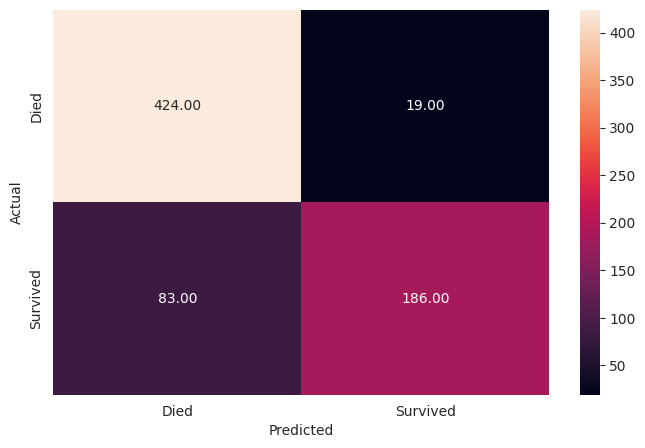

In [ ]:
# Using the model to make predictions on the training data
y_train_pred = dask_model.predict(x_train_scaled)

#Set the threshold of classification to be 0.5
y_train_pred = (y_train_pred > 0.5)

#Performance of model on training data
metrics_score(y_train,y_train_pred)

### Model Performance with validation data

6/6 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.77      0.93      0.84       106
           1       0.86      0.59      0.70        73

    accuracy                           0.79       179
   macro avg       0.81      0.76      0.77       179
weighted avg       0.81      0.79      0.78       179



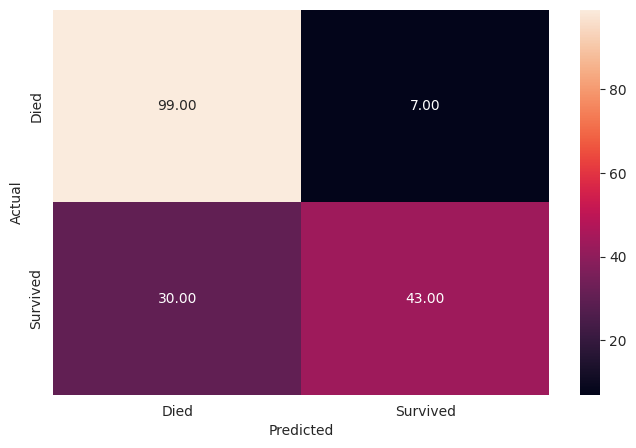

In [ ]:
#Making prediction using the model on the validation data to peformance metric.
y_pred=dask_model.predict(x_test_scaled)

#Set the threshold of classification to be 0.5
y_pred = (y_pred > 0.5)

#Performance on validation data
metrics_score(y_test,y_pred)

### ROC-AUC Tuning

6/6 [==============================] - 0s 4ms/step
Best Threshold=0.352301, G-Mean=0.769


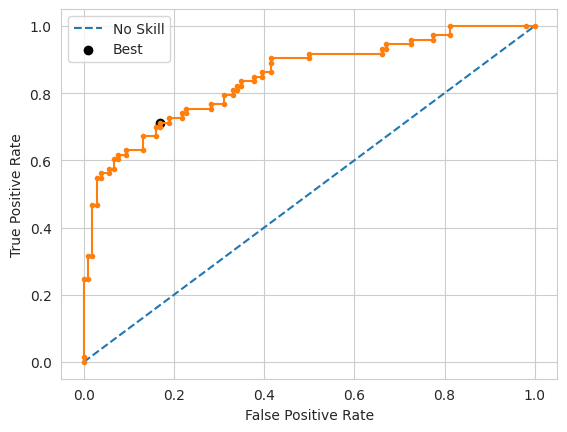

In [ ]:
# predict probabilities
yhatdask = dask_model.predict(x_test_scaled)

# keep probabilities for the positive outcome only
yhatdask = yhatdask[:, 0]

# calculate roc curves
fpr, tpr, thresholdsdask = roc_curve(y_test, yhatdask)

# calculate the g-mean for each threshold
gmeansdask = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeansdask)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholdsdask[ix], gmeansdask[ix]))

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

# show the plot
pyplot.show()

6/6 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       106
           1       0.74      0.70      0.72        73

    accuracy                           0.78       179
   macro avg       0.77      0.76      0.77       179
weighted avg       0.78      0.78      0.78       179



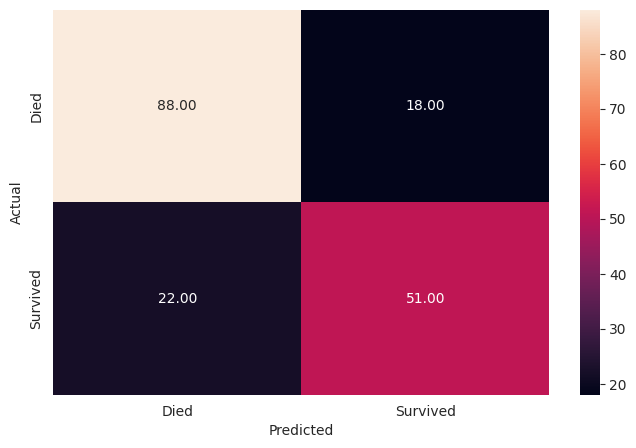

In [ ]:
#Making the prediction using the test data
y_pred_e4=dask_model.predict(x_test_scaled)

#Using the threshold value to convert the predicted data into true or false statements. If the predicted data is higher than threshold, it will be labelled true.
y_pred_e4 = (y_pred_e4 > thresholdsdask[ix])

metrics_score(y_test, y_pred_e4)

### Observations

-  Model accuracy on validation data stopped improving after 40 epochs.
- Accuracy on training data continues to improve after 40 epochs, resulting in more overfitting.
- Performance of model is poorer than model 4, with an accuracy of 78% after ROC-AUC tuning.
- It took ~2 hours to optimize this set of parameters


## Model 6: Grid Search CV on Model 4 with batch normalization and dropout tuning

### GridSearch Hyperparameter Tuning

In [166]:
backend.clear_session()
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [137]:
def create_model(lr,batch_size,dropout1,dropout2, momentum1, momentum2, epsilon1, epsilon2):
    # Fixing the seed for random number generators
    np.random.seed(42)

    # Initialize sequential model
    model = Sequential()
    model.add(Dense(64, activation='leaky_relu', input_dim = x_train.shape[1])) # Add the input layer and the first layer
    model.add(Dropout(dropout1))
    model.add(BatchNormalization(momentum = momentum1, epsilon = epsilon1))
    model.add(Dense(64,activation='leaky_relu'))
    model.add(Dropout(dropout2))
    model.add(BatchNormalization(momentum = momentum2, epsilon = epsilon2))
    model.add(Dense(1, activation='sigmoid'))

    #Defining the optimizer and learnign rate
    optimizer = Adamax(learning_rate = lr)

    #Using the settings for the sequential model above, create the model with the following algorithms
    model.compile(loss = 'binary_crossentropy',
                    optimizer = optimizer,
                    metrics=['accuracy'])

    return model

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping

#Create the classifer with their default values
keras_estimator = KerasClassifier(build_fn=create_model,
                                  epochs = 150,
                                  batch_size = 0,
                                  verbose=1)

# Setting the parameters to search
param_grid = {'batch_size':[32, 64],
              "lr":[0.0003, 0.0005],
              'dropout1':[0.1, 0.2],
              'dropout2':[0.1, 0.2],
              'momentum1': [0.9, 0.95],
              'epsilon1': [0.01, 0.1],
              'momentum2': [0.9, 0.95],
              'epsilon2': [0.01, 0.1],}

kfold_splits = 3

early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 5,
                               verbose = 1,
                               restore_best_weights=True)

# Defining the parameters for the gridsearchCV
grid = GridSearchCV(estimator=keras_estimator,
                     verbose=1,
                     cv=kfold_splits,
                     param_grid=param_grid,
                     n_jobs=-1)

In [ ]:
#There was an issue with the dattype not being numpy.float32, so I just converted it
x_train_scaled = np.asarray(x_train_scaled).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)

In [ ]:
# Took 6 hours to run this fitting
grid_result = grid.fit(x_train_scaled,
                       y_train,
                       validation_split=0.2,
                       callbacks=[early_stopping],
                       verbose=1)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 256 candidates, totalling 768 fits
Epoch 1/150
9/9 [==============================] - 3s 74ms/step - loss: 0.7463 - accuracy: 0.6011 - val_loss: 0.6213 - val_accuracy: 0.7273
Epoch 2/150
9/9 [==============================] - 0s 20ms/step - loss: 0.6511 - accuracy: 0.6714 - val_loss: 0.5884 - val_accuracy: 0.7413
Epoch 3/150
9/9 [==============================] - 0s 18ms/step - loss: 0.6395 - accuracy: 0.6819 - val_loss: 0.5563 - val_accuracy: 0.7203
Epoch 4/150
9/9 [==============================] - 0s 15ms/step - loss: 0.5869 - accuracy: 0.7047 - val_loss: 0.5310 - val_accuracy: 0.7343
Epoch 5/150
9/9 [==============================] - 0s 16ms/step - loss: 0.5522 - accuracy: 0.7346 - val_loss: 0.5112 - val_accuracy: 0.7622
Epoch 6/150
9/9 [==============================] - 0s 20ms/step - loss: 0.5276 - accuracy: 0.7452 - val_loss: 0.4939 - val_accuracy: 0.7622
Epoch 7/150
9/9 [==============================] - 0s 13ms/step - loss: 0.5228 - accuracy: 0.7645

These are the optimized parameters:

- Epoch 46: early stopping
- Parameters: {'batch_size': 64, 'dropout1': 0.1, 'dropout2': 0.2, 'epsilon1': 0.01, 'epsilon2': 0.01, 'lr': 0.0005, 'momentum1': 0.95, 'momentum2': 0.95}
- Best validation accuracy: 0.825881

### Creating model with optimized parameters

In [167]:
grid_model = create_model(batch_size=32,
                          lr=0.0003,
                          dropout1=0.1,
                          dropout2=0.2,
                          momentum1=0.9,
                          epsilon1=0.1,
                          momentum2=0.95,
                          epsilon2=0.1)

optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.0003)

grid_model.compile(loss='binary_crossentropy',
                   optimizer=optimizer,
                   metrics=['accuracy'])

grid_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                960       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                        

In [168]:
history_grid = grid_model.fit(x_train_scaled,
                            y_train,
                            epochs=50,
                            batch_size = 32,
                            verbose=1,
                            validation_split=0.2)

Epoch 1/50
18/18 [==============================] - 2s 19ms/step - loss: 0.7054 - accuracy: 0.6344 - val_loss: 0.6255 - val_accuracy: 0.6923
Epoch 2/50
18/18 [==============================] - 0s 5ms/step - loss: 0.6332 - accuracy: 0.6766 - val_loss: 0.5773 - val_accuracy: 0.6993
Epoch 3/50
18/18 [==============================] - 0s 5ms/step - loss: 0.6048 - accuracy: 0.6819 - val_loss: 0.5526 - val_accuracy: 0.7133
Epoch 4/50
18/18 [==============================] - 0s 5ms/step - loss: 0.5862 - accuracy: 0.6942 - val_loss: 0.5380 - val_accuracy: 0.7063
Epoch 5/50
18/18 [==============================] - 0s 7ms/step - loss: 0.5863 - accuracy: 0.7118 - val_loss: 0.5124 - val_accuracy: 0.7273
Epoch 6/50
18/18 [==============================] - 0s 5ms/step - loss: 0.5400 - accuracy: 0.7452 - val_loss: 0.5034 - val_accuracy: 0.7413
Epoch 7/50
18/18 [==============================] - 0s 6ms/step - loss: 0.5192 - accuracy: 0.7417 - val_loss: 0.4895 - val_accuracy: 0.7483
Epoch 8/50
18/18 [=

### Model Accuracy and Loss with Epochs

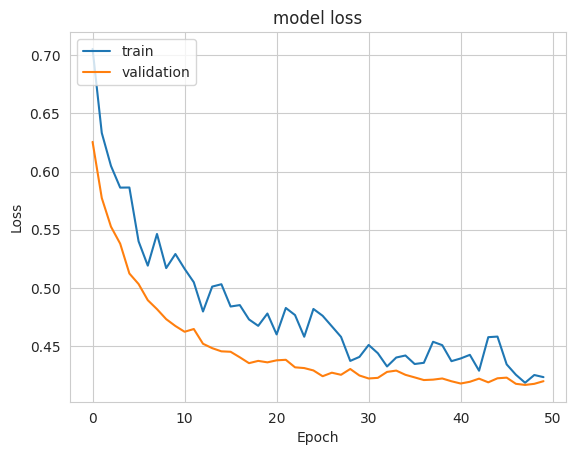

In [169]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_grid.history['loss'])
plt.plot(history_grid.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

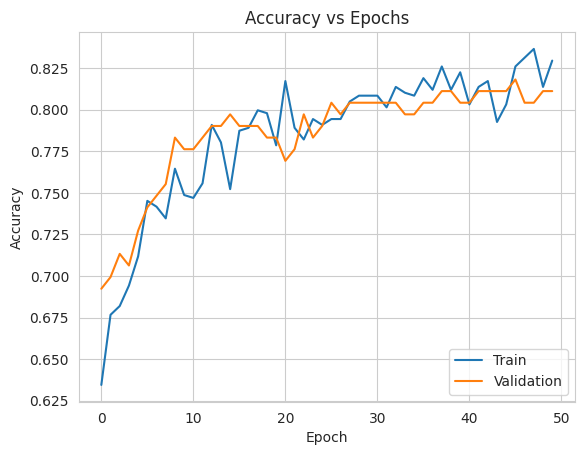

In [170]:
#Plotting Epoch vs accuracy
plt.plot(history_grid.history['accuracy'])
plt.plot(history_grid.history['val_accuracy'])
plt.title('Accuracy vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

### Model Performance on training data

23/23 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       443
           1       0.84      0.68      0.75       269

    accuracy                           0.83       712
   macro avg       0.83      0.80      0.81       712
weighted avg       0.83      0.83      0.83       712



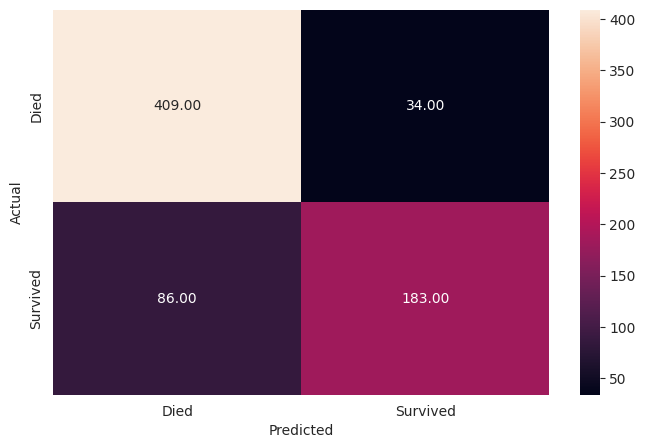

In [171]:
# Using the model to make predictions on the training data
y_train_pred = grid_model.predict(x_train_scaled)

#Set the threshold of classification to be 0.5
y_train_pred = (y_train_pred > 0.5)

#Performance of model on training data
metrics_score(y_train,y_train_pred)

### Model Performance with validation data

6/6 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       106
           1       0.84      0.64      0.73        73

    accuracy                           0.80       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.81      0.80      0.80       179



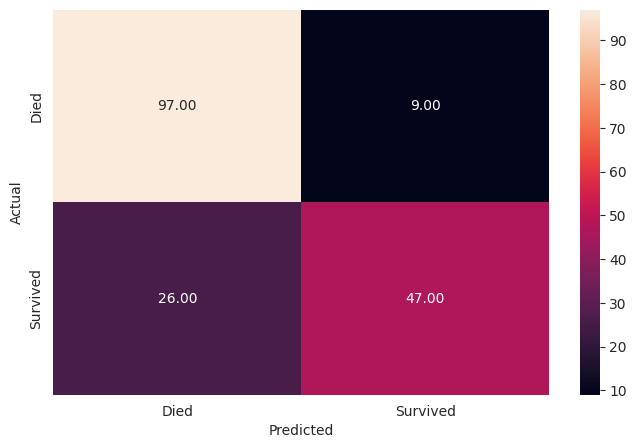

In [172]:
#Making prediction using the model on the validation data to peformance metric.
y_pred=grid_model.predict(x_test_scaled)

#Set the threshold of classification to be 0.5
y_pred = (y_pred > 0.5)

#Performance on validation data
metrics_score(y_test,y_pred)

### ROC-AUC Tuning

6/6 [==============================] - 0s 2ms/step
Best Threshold=0.461143, G-Mean=0.799


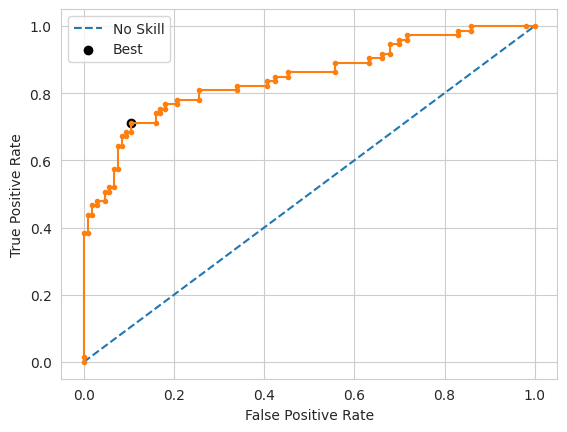

In [173]:
# predict probabilities
yhatgrid = grid_model.predict(x_test_scaled)

# keep probabilities for the positive outcome only
yhatgrid = yhatgrid[:, 0]

# calculate roc curves
fpr, tpr, thresholdsgrid = roc_curve(y_test, yhatgrid)

# calculate the g-mean for each threshold
gmeansgrid = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeansgrid)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholdsgrid[ix], gmeansgrid[ix]))

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

# show the plot
pyplot.show()

6/6 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       106
           1       0.82      0.70      0.76        73

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.80       179
weighted avg       0.82      0.82      0.81       179



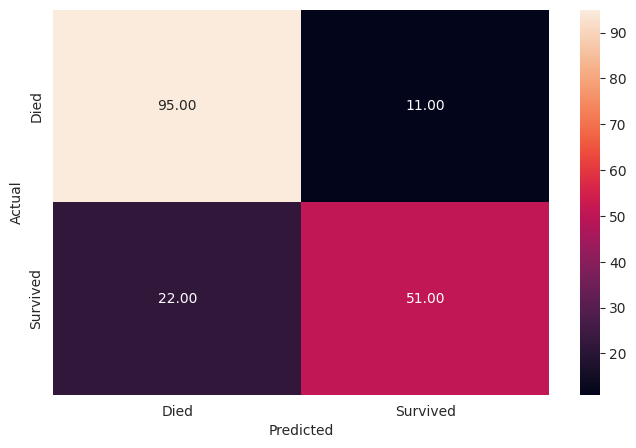

In [174]:
#Making the prediction using the test data
y_pred_grid=grid_model.predict(x_test_scaled)

#Using the threshold value to convert the predicted data into true or false statements. If the predicted data is higher than threshold, it will be labelled true.
y_pred_grid = (y_pred_grid > thresholdsgrid[ix])

metrics_score(y_test, y_pred_grid)

### Observations

-  Loss curve is smooth, accuracy curve is a little bit rough.
-  Model performance on training data is 83, while performance on validation data is 80. There is still some overfitting going on.
- After AUC-ROC tuning, model reached an accuracy of 82% on validation data, higher than previous models.


# Conclusion

## Findings from EDA

- Women and children had higher survival rate
- Pclass 1 passengers had higher survival rate
- Smaller ticket numbers have higher survival rate
- Cabin data was too unrepresentative of the population, so the column was dropped.
- Travelling with small family members have higher chance of survival as compared to solo passengers or passengers with big family.



## Findings from Deep Learning Model Tuning

- The version of python, keras and tensorflow can be quite meddlesome, as only specific versions were compatible with each other, or the coding syntax will be different.
- It took roughly 6 hours to complete the gridsearchCV optimization, and 2 hours to complete the DaskgridsearchCV. According to research, DaskgridsearchCV is more suitable for larger and complex datasets, and will optimize faster.
-  There is a need for a better tuning heuristic to follow, the automated optimizers are unable to include every parameter. It will take too much resources to complete.
- There are many parameters that can be tuned, each optimizer, layer, regularization technique have their own customizable settings.
- I could only reach an accuracy of 82% after so much tuning. There must be other ways to improve the accuracy, such as feature engineering, or other kinds of regression models.

## Recommendations

- More feature engineering could be done to improve the accuracy:
    - Family Size - Can be broken down into bins of family size i.e. solo, small family and big family. small family got highest chance of surviving, wihle the other 2 have much lower.
    - Ticket Number - People with lower ticket numbers seem to have higher chance of surviving, and there seems to be 3 bigger categories. one is smaller than 200,000, other is from 200,000 to 400,000, then the last group is larger than 3,000,000.
    - Title in names - There were titles assigned to each person in the 'Name' data. This could have given a clue to more factors that could affect the survival rate.

- The data is small for a deep learning model. This is why the model's performance on the training data is not high in the first place. More data may be created through **data augmentation**.

- Cabin data - Although unrepresentative of the population distribution, the available cabin data can be taken out to create another model that would make the prediction for the unseen data that has cabin numbers.

- Ensemble techniques - We can create different kinds of model and aggregate their predictions.

- We can try clustering techniques to provide some structure to the data, it might help with the model learning, and we can remove insignificant clusters that might distract the model's learning.

# Final Predictions

In [ ]:
final_to_predict.head(1)

,Age,Fare,family,ticket_numbers,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,ticket_length_3,ticket_length_4,ticket_length_5,ticket_length_6,ticket_length_7,PassengerId,predictions
0,0.408718,-0.502509,-0.553443,0.132042,-0.534933,0.957826,0.755929,2.843757,-1.350676,-0.120678,-0.486504,-0.675608,1.133205,-0.199502,892,0


In [ ]:
x_test_scaled.head(1)

,Age,Fare,family,ticket_numbers,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,ticket_length_3,ticket_length_4,ticket_length_5,ticket_length_6,ticket_length_7
0,1.360125,-0.139232,-0.575156,-0.430966,-0.516627,-1.094318,-1.363612,-0.31427,0.618485,-0.092188,-0.468165,1.622545,-0.977775,-0.213357


In [ ]:
#Make prediction using model 4, and drop ID column as it is not needed forthe prediction
final_to_predict = test_x_scaled
final_to_predict['predictions']= grid_model.predict(final_to_predict.drop('PassengerId',axis=1))

# Apply the ROC-AUC best threshold for model's prediction
final_to_predict['predictions'] = final_to_predict['predictions'].apply(lambda x: 1 if x>thresholdsgrid[ix] else 0)

#Save the predicted data into the csv file
final_to_predict[['PassengerId','predictions']].to_csv("titanic_predictions.csv",index=False)

14/14 [==============================] - 0s 3ms/step
